## Chapter 1 - Setup and Dataset Preparation
#### 1.1. Setup

In [37]:
import sys
print(sys.executable)


/home/george/anaconda3/envs/py310/bin/python


In [39]:
# Libraries for Data Manipulation, Pre-Processing and Visualisations
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Libraries for Fourier and KNN 
from sklearn.impute import KNNImputer
from scipy.optimize import curve_fit

# Libraries for ML and DL models
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from prophet import Prophet

# Libraries for statistical 
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

# Libraries for handling logs
import logging


In [72]:
# Setup for Tensorflow on GPU and Log Settings

print("TensorFlow version:", tf.__version__)

# Print GPUs recognised by tensorflow
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Run tensorflow on GPU
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU')[0], 'GPU')  

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Supress Tensorflow warnings
logging.getLogger('tensorflow').setLevel(logging.ERROR) # Further supressing of tensorflow logs


TensorFlow version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [41]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

#### 1.2 Processing and Saving Sensor Data by Home

In [9]:
directory = r"./raw_data/hourly_readings/"

# Function to extract components (home, room, sensor, probe) from filenames
def parse_filename(filename):
    # Assumes filename format: home<number>_<room><number>_sensor<number>_<probe>.csv
    parts = filename.replace('.csv.gz', '').replace('.csv', '').split('_')
    home = parts[0]
    room = parts[1]
    sensor = parts[2]
    probe = "_".join(parts[3:])
    return home, room, sensor, probe

# Initialize a dictionary to hold DataFrames for each home
home_dfs = {}

# Iterate over all CSV files in the directory
for i, file in enumerate(os.listdir(directory)):

    if file.endswith(".csv") or file.endswith('.csv.gz'):
        file_path = os.path.join(directory, file)

        # Read the CSV
        df = pd.read_csv(file_path, header=None, names=['timestamp', 'value'])

        # Convert the timestamp into datetime format
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

        # Extract metadata from the filename to create unique column names
        home, room, sensor, probe = parse_filename(file)
        sensor_column_name = f'{home}_{room}_{sensor}_{probe}'

        # Add the sensor data as a new column with the unique sensor name
        df[sensor_column_name] = df['value']
        df.drop(columns='value', inplace=True)

        # Check if this home already has a DataFrame, if not, initialize one
        if home not in home_dfs:
            home_dfs[home] = df  # First file for this home
        else:
            # Incrementally merge with how='outer' to include all timestamps
            home_dfs[home] = pd.merge(home_dfs[home], df, on='timestamp', how='outer')

        # For progress feedback
        if i % 100 == 0:
            print(f"Processed {i} files...")

# Save each home's DataFrame to a separate CSV file
for home, home_df in home_dfs.items():
    # Sort the DataFrame by timestamp
    home_df.sort_values(by="timestamp", inplace=True)

    # Define the output file name
    output_file_path = os.path.join(r"./ind-homes", f"home_{home}.csv")
    
    # Save the DataFrame to CSV
    home_df.to_csv(output_file_path, index=False)

    print(f"Saved {output_file_path}")

print("Processing complete. Separate files for each home have been generated.")

Processed 0 files...
Processed 100 files...
Processed 200 files...
Processed 300 files...
Processed 400 files...
Processed 500 files...
Processed 600 files...
Processed 700 files...
Processed 800 files...
Processed 900 files...
Processed 1000 files...
Processed 1100 files...
Processed 1200 files...
Processed 1300 files...
Processed 1400 files...
Processed 1500 files...
Processed 1600 files...
Processed 1700 files...
Processed 1800 files...
Processed 1900 files...
Processed 2000 files...
Processed 2100 files...
Processed 2200 files...
Processed 2300 files...
Processed 2400 files...
Processed 2500 files...
Processed 2600 files...
Processed 2700 files...
Processed 2800 files...
Processed 2900 files...
Processed 3000 files...
Processed 3100 files...
Processed 3200 files...
Processed 3300 files...
Processed 3400 files...
Processed 3500 files...
Processed 3600 files...
Processed 3700 files...
Processed 3800 files...
Processed 3900 files...
Processed 4000 files...
Processed 4100 files...
Proc

## Chapter 2 - Exploratory Data Analysis 

#### 2.1 Generating a Summary of Sensor Data Across Homes

In [16]:
directory = r"./ind-homes/"  # Directory where the homeXXX.csv files are located

# Function to extract general sensor type from column names
def parse_sensor_type(column_name):
    # Remove home prefix and split by underscores
    parts = column_name.split('_')
    # Ignore the home number ('homeXX') in the first part
    if parts[0].startswith('home'):
        parts = parts[1:]
    # Remove numerical suffixes and 'sensor' word
    cleaned_parts = []
    for part in parts:
        # Remove numeric characters
        part = re.sub(r'\d+', '', part)
        # Remove 'sensor' word
        part = part.replace('sensor', '')
        # Only add non-empty parts
        if part:
            cleaned_parts.append(part)
    # Rejoin the parts to form the general sensor type
    sensor_type = '_'.join(cleaned_parts)
    return sensor_type

# Initialize a set to collect all sensor types
all_sensor_types = set()

# Collect all home CSV files
home_files = [f for f in os.listdir(directory) if f.startswith('home') and f.endswith('.csv')]

# First pass to collect all sensor types
for file in home_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    # Exclude 'timestamp' column
    sensor_columns = [col for col in df.columns if col != 'timestamp']
    for col in sensor_columns:
        sensor_type = parse_sensor_type(col)
        all_sensor_types.add(sensor_type)

# Convert set to sorted list for consistent column order
all_sensor_types = sorted(all_sensor_types)

# Initialize list to hold summary data
summary_data = []

# Second pass to compute summary per home
for file in home_files:
    file_path = os.path.join(directory, file)
    df = pd.read_csv(file_path)
    # Ensure 'timestamp' column is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    home_number_match = re.search(r'home(\d+).csv', file)
    if home_number_match:
        home_number = home_number_match.group(1)
    else:
        home_number = file.replace('home', '').replace('.csv', '')
    earliest_timestamp = df['timestamp'].min()
    latest_timestamp = df['timestamp'].max()
    num_rows = len(df)

    # Initialize dict for sensor counts
    sensor_counts = dict.fromkeys(all_sensor_types, 0)

    # Count non-null data points for each sensor type
    for col in df.columns:
        if col != 'timestamp':
            sensor_type = parse_sensor_type(col)
            count_non_null = df[col].count()
            sensor_counts[sensor_type] += count_non_null

    # Prepare the row data
    row_data = {
        'home_number': home_number,
        'earliest_timestamp': earliest_timestamp,
        'latest_timestamp': latest_timestamp,
        'number_of_rows': num_rows
    }
    # Add sensor counts to row data
    row_data.update(sensor_counts)
    # Append to summary data list
    summary_data.append(row_data)

# Create DataFrame for summary
summary_df = pd.DataFrame(summary_data)

print(summary_df)
# Save summary DataFrame to CSV
# summary_df.to_csv('summary2.csv', index=False)

    home_number  earliest_timestamp    latest_timestamp  number_of_rows  \
0           100 2017-03-07 14:00:00 2018-06-30 23:00:00           11155   
1           101 2017-03-09 08:00:00 2018-06-26 13:00:00           10941   
2           102 2016-10-25 14:00:00 2018-06-12 07:00:00           10236   
3           105 2017-04-25 13:00:00 2018-06-23 19:00:00            9893   
4           106 2017-04-13 10:00:00 2018-06-14 11:00:00            9903   
..          ...                 ...                 ...             ...   
250          94 2017-02-21 08:00:00 2018-06-30 23:00:00           11545   
251          96 2017-02-28 10:00:00 2018-06-30 23:00:00            8495   
252          97 2017-03-02 08:00:00 2018-05-13 10:00:00            9610   
253          98 2017-03-02 11:00:00 2018-06-30 23:00:00           11332   
254          99 2017-03-07 08:00:00 2018-06-30 23:00:00            9697   

     bathroom_c_electric-mains_electric-combined  bathroom_gas-pulse_gas  \
0                      

#### 2.2 Computing Sensor Statistics Across Homes

In [18]:
# Function to compute min, max, and average values for each sensor type across all homes
def compute_sensor_stats(directory, all_sensor_types):
    sensor_stats = {sensor: {'min': float('inf'), 'max': float('-inf'), 'sum': 0.0, 'count': 0} for sensor in all_sensor_types}
    for file in os.listdir(directory):
        if file.startswith('home') and file.endswith('.csv'):
            file_path = os.path.join(directory, file)
            df = pd.read_csv(file_path)
            for col in df.columns:
                if col != 'timestamp':
                    sensor_type = parse_sensor_type(col)
                    if sensor_type in sensor_stats:
                        column_data = df[col].dropna()
                        if not column_data.empty:
                            current_min = column_data.min()
                            current_max = column_data.max()
                            sensor_stats[sensor_type]['min'] = min(sensor_stats[sensor_type]['min'], current_min)
                            sensor_stats[sensor_type]['max'] = max(sensor_stats[sensor_type]['max'], current_max)
                            sensor_stats[sensor_type]['sum'] += column_data.sum()
                            sensor_stats[sensor_type]['count'] += column_data.count()

    # Infer units based on sensor type
    sensor_units = {
        'temperature': '°C',
        'humidity': '% RH',
        'light': 'Uncalibrated units',
        'electric_combined': 'Watts',
        'electric_mains': 'Watts',
        'electric_subcircuit': 'Watts',
        'electric_appliance': 'Watts',
        'electric': 'Watts',
        'gas_pulse': 'Watt hours',
        'gas': 'Watt hours',
        'power': 'Watts',
        'clamp_temperature': '°C',
        # Add more sensor types and their units as needed
    }

    # Prepare summary data
    summary_list = []
    for sensor, values in sensor_stats.items():
        unit = sensor_units.get(sensor, 'Unknown')
        min_val = values['min'] if values['min'] != float('inf') else None
        max_val = values['max'] if values['max'] != float('-inf') else None
        average_val = values['sum'] / values['count'] if values['count'] > 0 else None
        summary_list.append({
            'sensor_type': sensor,
            'min_value': min_val,
            'max_value': max_val,
            'average_value': average_val,
            'unit': unit
        })

    # Create DataFrame and save to CSV
    stats_df = pd.DataFrame(summary_list)
    #stats_df.to_csv('sensor_stats.csv', index=False)
    #print("Sensor stats CSV has been generated as 'sensor_stats.csv'.")
    return stats_df

# Call the function to compute min, max, and average values
stats_df = compute_sensor_stats(directory, all_sensor_types)
print(stats_df)

                                     sensor_type  min_value  max_value  \
0    bathroom_c_electric-mains_electric-combined        0.0     4146.0   
1                         bathroom_gas-pulse_gas      112.0    17380.0   
2                         bathroom_room_humidity       10.0     1100.0   
3                            bathroom_room_light        0.0    65340.0   
4                      bathroom_room_temperature        0.0      600.0   
..                                           ...        ...        ...   
150        utility_tempprobe_hot-water-cold-pipe       36.0      470.0   
151         utility_tempprobe_hot-water-hot-pipe       42.0      691.0   
152             utility_tempprobe_radiator-input      118.0      503.0   
153            utility_tempprobe_radiator-output      119.0      500.0   
154                       utility_tempprobe_sink      115.0      346.0   

     average_value     unit  
0       357.939517  Unknown  
1      2907.294805  Unknown  
2       572.145833  U

#### 2.3 Generating Combined Sensor Summary with Units

In [19]:
# output_file = 'sensor_summary_combined.csv'

# Function to extract general sensor type from the full sensor type string
def extract_sensor_type(full_sensor_type):
    parts = full_sensor_type.split('_')
    return '_'.join(parts[1:])  # Ignore the room part (first element)

# Extract sensor types without room prefixes
stats_df['clean_sensor_type'] = stats_df['sensor_type'].apply(extract_sensor_type)

# Define correct units for each sensor type
sensor_units = {
    'temperature': '°C',
    'humidity': '% RH',
    'light': 'Uncalibrated units',
    'electric-combined': 'Watts',
    'electric': 'Watts',
    'electric_appliance': 'Watts',
    'gas-pulse_gas': 'Watt hours',
    'power': 'Watts',
    'clamp_temperature': '°C',
    'tempprobe': '°C',
    'room_humidity': '% RH',
    'room_temperature': '°C',
    'room_light': 'Uncalibrated units',
    'heater_temperature': '°C',
    'heater_humidity': '% RH',
    # Add more sensor types and their units as needed
}

# Function to infer unit from sensor type
def infer_unit(sensor_type):
    for key in sensor_units:
        if key in sensor_type:
            return sensor_units[key]
    return 'Unknown'

# Group by sensor type, ignoring room prefixes, and calculate combined stats
summary = stats_df.groupby('clean_sensor_type').agg(
    min_value=('min_value', 'min'),
    max_value=('max_value', 'max'),
    sum_value=('average_value', 'sum'),
    count=('average_value', 'count')  # To calculate global average
).reset_index()

# Calculate average values
summary['average_value'] = summary['sum_value'] / summary['count']

# Infer units based on sensor type
summary['unit'] = summary['clean_sensor_type'].apply(infer_unit)

# Drop the sum and count columns as they are no longer needed
summary.drop(columns=['sum_value', 'count'], inplace=True)

# Rename the columns for clarity
summary.rename(columns={'clean_sensor_type': 'sensor_type'}, inplace=True)

print(summary)
# Save the summary to a new CSV file
#summary.to_csv(output_file, index=False)

#print(f'Summary has been saved to {output_file}.')

                           sensor_type  min_value  max_value  average_value  \
0   c_electric-mains_electric-combined        0.0    11649.0     382.358709   
1     electric-mains_electric-combined        0.0     7266.0     265.738371   
2                        gas-pulse_gas  -115204.0  3649578.0    4078.518923   
3                    heatcook_humidity      202.0     1037.0     538.390760   
4                       heatcook_light        0.0     7664.0      24.846236   
5                 heatcook_temperature       63.0      344.0     196.147661   
6                      heater_humidity       49.0      879.0     512.845745   
7                         heater_light        0.0     7597.0      52.668859   
8                   heater_temperature       66.0      600.0     189.309536   
9                        room_humidity       10.0     1100.0     540.861817   
10                          room_light        0.0    65535.0     114.054778   
11                    room_temperature        0.0   

#### 2.4 Generating Sensor by Room/Device Counts Summary and Summary Statistics for each Sensor

In [21]:
# Exclude non-sensor columns
sensor_columns = summary_df.columns.difference(
    ['home_number', 'earliest_timestamp', 'latest_timestamp', 'number_of_rows'])

# Initialize a nested dictionary to hold counts
sensor_room_counts = {}
sensor_stats = {}

# Process each sensor column to extract room and sensor type
for col in sensor_columns:
    # Clean the column name by removing numeric suffixes and 'sensor' word
    col_cleaned = re.sub(r'\d+', '', col)
    col_cleaned = col_cleaned.replace('sensor', '')
    parts = col_cleaned.split('_')

    if len(parts) >= 2:
        room = parts[0]
        sensor_type = '_'.join(parts[1:])
    else:
        continue  # Skip columns that don't match the expected pattern

    # Ensure the sensor_type exists in the dictionary for room counts
    if sensor_type not in sensor_room_counts:
        sensor_room_counts[sensor_type] = {}
    if room not in sensor_room_counts[sensor_type]:
        sensor_room_counts[sensor_type][room] = 0

    # Count the number of homes where the number of valid datapoints is greater than 0
    count_homes = (summary_df[col] > 0).sum()
    sensor_room_counts[sensor_type][room] += count_homes

    # Calculate min/max statistics across all homes for the sensor
    min_value = summary_df[col].min()
    max_value = summary_df[col].max()

    # Infer units based on sensor type
    if 'temperature' in sensor_type:
        unit = '°C'
    elif 'humidity' in sensor_type:
        unit = '%'
    elif 'electric' in sensor_type or 'power' in sensor_type:
        unit = 'W'
    elif 'gas' in sensor_type:
        unit = 'Wh'
    elif 'light' in sensor_type:
        unit = 'Undetermined'
    else:
        unit = 'Unknown'

    # Store sensor statistics
    if sensor_type not in sensor_stats:
        sensor_stats[sensor_type] = {'min': min_value, 'max': max_value, 'unit': unit}

# Convert the nested dictionary for room counts to a DataFrame
sensor_summary_df = pd.DataFrame.from_dict(sensor_room_counts, orient='index').fillna(0).astype(int)

# Sort the rows and columns for better readability
sensor_summary_df = sensor_summary_df.sort_index()
sensor_summary_df = sensor_summary_df.reindex(sorted(sensor_summary_df.columns), axis=1)

# Save the room summary to CSV
#sensor_summary_df.to_csv('room_summary2.csv')
print(sensor_summary_df)
# Convert sensor stats to DataFrame and save to CSV
sensor_stats_df = pd.DataFrame(sensor_stats).T
# sensor_stats_df.to_csv('sensor_stats_summary.csv')

#print("Room summary CSV has been generated as 'room_summary.csv'.")
#print("Sensor stats summary CSV has been generated as 'sensor_stats_summary.csv'.")

                                    bathroom  bedroom  conservatory  cupboard  \
c_electric-mains_electric-combined         1        7             0         4   
electric-mains_electric-combined           0        0             0         0   
gas-pulse_gas                              6        6             0         4   
heatcook_humidity                          0        0             0         0   
heatcook_light                             0        0             0         0   
heatcook_temperature                       0        0             0         0   
heater_humidity                            0        0             0         0   
heater_light                               0        0             0         0   
heater_temperature                         0        0             0         0   
room_humidity                            254      255             8         1   
room_light                               254      255             8         1   
room_temperature            

In [22]:
print(f'Sensor stats summary {sensor_stats_df}')

Sensor stats summary                                    min    max          unit
c_electric-mains_electric-combined   0   4679             W
gas-pulse_gas                        0   4565            Wh
room_humidity                        0  24426             %
room_light                           0  24423  Undetermined
room_temperature                     0  24426            °C
tempprobe_bath                       0  14401       Unknown
tempprobe_central-heating-flow       0  11861       Unknown
tempprobe_central-heating-return     0  11861       Unknown
tempprobe_hot-water-cold-pipe        0  11838       Unknown
tempprobe_hot-water-hot-pipe         0  11838       Unknown
tempprobe_radiator-input             0  14390       Unknown
tempprobe_radiator-output            0  12147       Unknown
tempprobe_shower                     0  14401       Unknown
tempprobe_sink                       0  12033       Unknown
electric-mains_electric-combined     0  12149             W
heatcook_humidity  

## Chapter 3 - Cleaning and Feature Engineering

#### 3.1 Cleaning and Processing Files for Electricity and Gas Data

In [23]:
# Directories
INPUT_DIR = "./ind-homes"
OUTPUT_DIR = "./ind-homes-clean"
# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Lists to track ignored files
ignored_files = []

# Function to clean a single file
def clean_file(file_path, output_path):
    """
    Cleans the given CSV file from the ind-homes folder and saves the cleaned version.

    Args:
        file_path (str): The path to the input file.
        output_path (str): The path to save the cleaned file.
    """
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Filter columns: keep 'timestamp' and columns containing 'elec' or 'gas'
    relevant_columns = ['timestamp'] + [col for col in df.columns if 'elec' in col or 'gas' in col]
    df = df[relevant_columns]

    # Ensure 'timestamp' is in datetime format
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

    # Check percentage of missing values for 'elec' and 'gas'
    for col in df.columns:
        if 'elec' in col or 'gas' in col:
            missing_percentage = df[col].isna().mean() * 100
            if missing_percentage > 50:
                ignored_files.append((os.path.basename(file_path), col, missing_percentage))
                return  # Ignore this file completely if one column exceeds 50% missing

    # Impute missing values
    for col in df.columns:
        if 'elec' in col:
            df[col] = df[col].ffill().bfill()  # Forward and backward fill
        elif 'gas' in col:
            df[col] = df[col].fillna(0)  # Fill missing gas values with 0

    # Save the cleaned file
    df.to_csv(output_path, index=False)

# Function to check for missing values in cleaned files
def check_missing_values(directory):
    """
    Checks for missing values in all cleaned files and provides a summary.

    Args:
        directory (str): Path to the directory containing cleaned CSV files.

    Returns:
        None
    """
    missing_summary = []
    print("\nMissing Value Check:")
    for file_name in os.listdir(directory):
        if file_name.endswith(".csv"):
            file_path = os.path.join(directory, file_name)
            df = pd.read_csv(file_path)
            missing_counts = df.isna().sum()
            total_missing = missing_counts.sum()
            
            if total_missing > 0:
                print(f"{file_name}: {total_missing} missing values.")
                missing_summary.append((file_name, total_missing))
            else:
                print(f"{file_name}: No missing values.")

    if missing_summary:
        print("\nSummary of Files with Missing Data:")
        for file, count in missing_summary:
            print(f"{file}: {count} missing values")
    else:
        print("\nAll cleaned files have no missing values.")

# Process files in input directory
for file_name in os.listdir(INPUT_DIR):
    if file_name.endswith(".csv"):
        input_file_path = os.path.join(INPUT_DIR, file_name)
        output_file_path = os.path.join(OUTPUT_DIR, file_name)

        # Clean and save the file (or ignore if conditions aren't met)
        clean_file(input_file_path, output_file_path)
        if os.path.exists(output_file_path):
            print(f"Cleaned and saved: {output_file_path}")

# Report ignored files
if ignored_files:
    print("\nIgnored Files Summary:")
    for file_name, col, percent_missing in ignored_files:
        print(f"{file_name}: Column '{col}' has {percent_missing:.2f}% missing values (> 50%).")
else:
    print("\nNo files were ignored due to missing value thresholds.")

# Perform a final check for missing values in cleaned files
check_missing_values(OUTPUT_DIR)

print("All files have been processed, cleaned, and checked for missing values.")

Cleaned and saved: ./ind-homes-clean\home_home100.csv
Cleaned and saved: ./ind-homes-clean\home_home107.csv
Cleaned and saved: ./ind-homes-clean\home_home113.csv
Cleaned and saved: ./ind-homes-clean\home_home116.csv
Cleaned and saved: ./ind-homes-clean\home_home118.csv
Cleaned and saved: ./ind-homes-clean\home_home119.csv
Cleaned and saved: ./ind-homes-clean\home_home121.csv
Cleaned and saved: ./ind-homes-clean\home_home124.csv
Cleaned and saved: ./ind-homes-clean\home_home138.csv
Cleaned and saved: ./ind-homes-clean\home_home139.csv
Cleaned and saved: ./ind-homes-clean\home_home146.csv
Cleaned and saved: ./ind-homes-clean\home_home148.csv
Cleaned and saved: ./ind-homes-clean\home_home151.csv
Cleaned and saved: ./ind-homes-clean\home_home152.csv
Cleaned and saved: ./ind-homes-clean\home_home160.csv
Cleaned and saved: ./ind-homes-clean\home_home161.csv
Cleaned and saved: ./ind-homes-clean\home_home162.csv
Cleaned and saved: ./ind-homes-clean\home_home164.csv
Cleaned and saved: ./ind-hom

#### 3.2 Cleaning and Processing Files for Weather Data

##### 3.2.1 Inspect Missing Gaps for each Location

In [31]:
output_dir = 'raw_weather_data_by_location'
os.makedirs(output_dir, exist_ok=True)

weather_data = pd.read_csv('raw_data/forecast.csv', delimiter='\t', parse_dates=['dateforecastfor', 'dateforecastmade'], index_col='dateforecastfor')
weather_data = weather_data.sort_index()
min_max_temp = weather_data[['locationid', 'maxtemp', 'mintemp']]


location_dataframes = {}
for loc in min_max_temp['locationid'].unique().tolist():
    loc_data = min_max_temp[min_max_temp['locationid'] == loc]
    
    min_date = loc_data.index.min()
    max_date = loc_data.index.max()
    
    full_date_range = pd.date_range(start=min_date, end=max_date)
    
    available_dates = loc_data.index
    
    missing_dates = full_date_range.difference(available_dates)
    
    print(f"Location: {loc}")
    print(f"Min Date: {min_date}")
    print(f"Max Date: {max_date}")
    print(f"Total Missing Dates: {len(missing_dates)}")
    print(f"Missing Date Range: {missing_dates.min()} to {missing_dates.max()}" if len(missing_dates) > 0 else "No missing dates")
    print("")
    
    # Create a single df for each location including the missing dates
    full_dates_df = pd.DataFrame({'date': full_date_range})
    full_dates_df.set_index('date', inplace=True)
    
    # Merge the complete date range with the location data
    merged_data = full_dates_df.merge(loc_data, left_index=True, right_index=True, how='left')
    
    # Store the data in the location-specific file
    file_path = os.path.join(output_dir, f"{loc}_data.csv")
    merged_data.to_csv(file_path)
    
    location_dataframes[f"{loc}_data"] = merged_data
    
    print(f"DataFrame created and saved for location: {loc}")

Location: Edinburgh
Min Date: 2016-08-10 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 55
Missing Date Range: 2018-02-17 00:00:00 to 2018-04-12 00:00:00

DataFrame created and saved for location: Edinburgh
Location: Fife
Min Date: 2017-11-28 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 99
Missing Date Range: 2017-12-03 00:00:00 to 2018-12-27 00:00:00

DataFrame created and saved for location: Fife
Location: EastLothian
Min Date: 2017-11-28 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 94
Missing Date Range: 2017-12-03 00:00:00 to 2018-12-27 00:00:00

DataFrame created and saved for location: EastLothian
Location: WestLothian
Min Date: 2017-11-28 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 57
Missing Date Range: 2018-02-16 00:00:00 to 2018-12-15 00:00:00

DataFrame created and saved for location: WestLothian
Location: Midlothian
Min Date: 2017-11-28 00:00:00
Max Date: 2018-12-30 00:00:00
Total Missing Dates: 66
Missing Date Rang

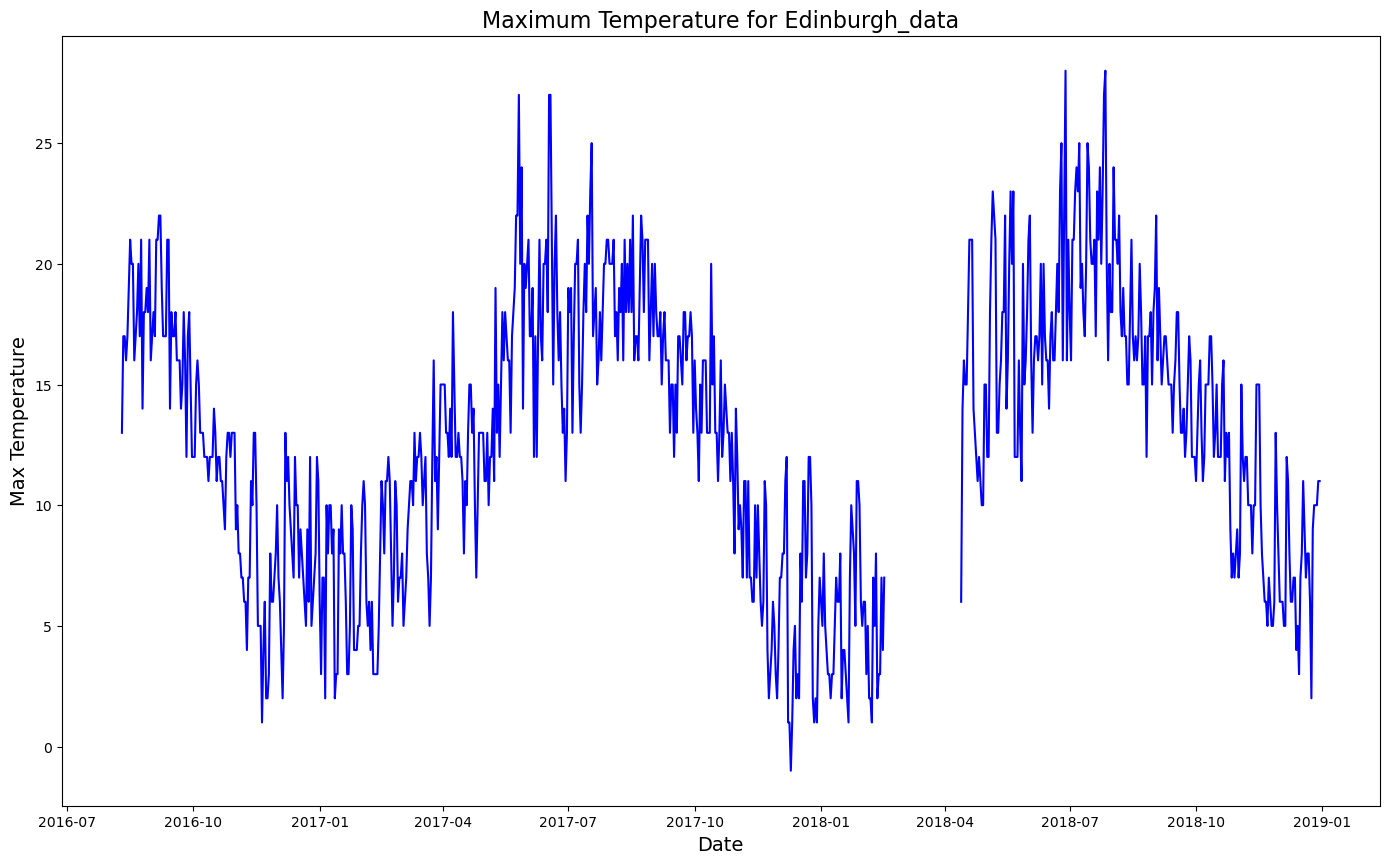

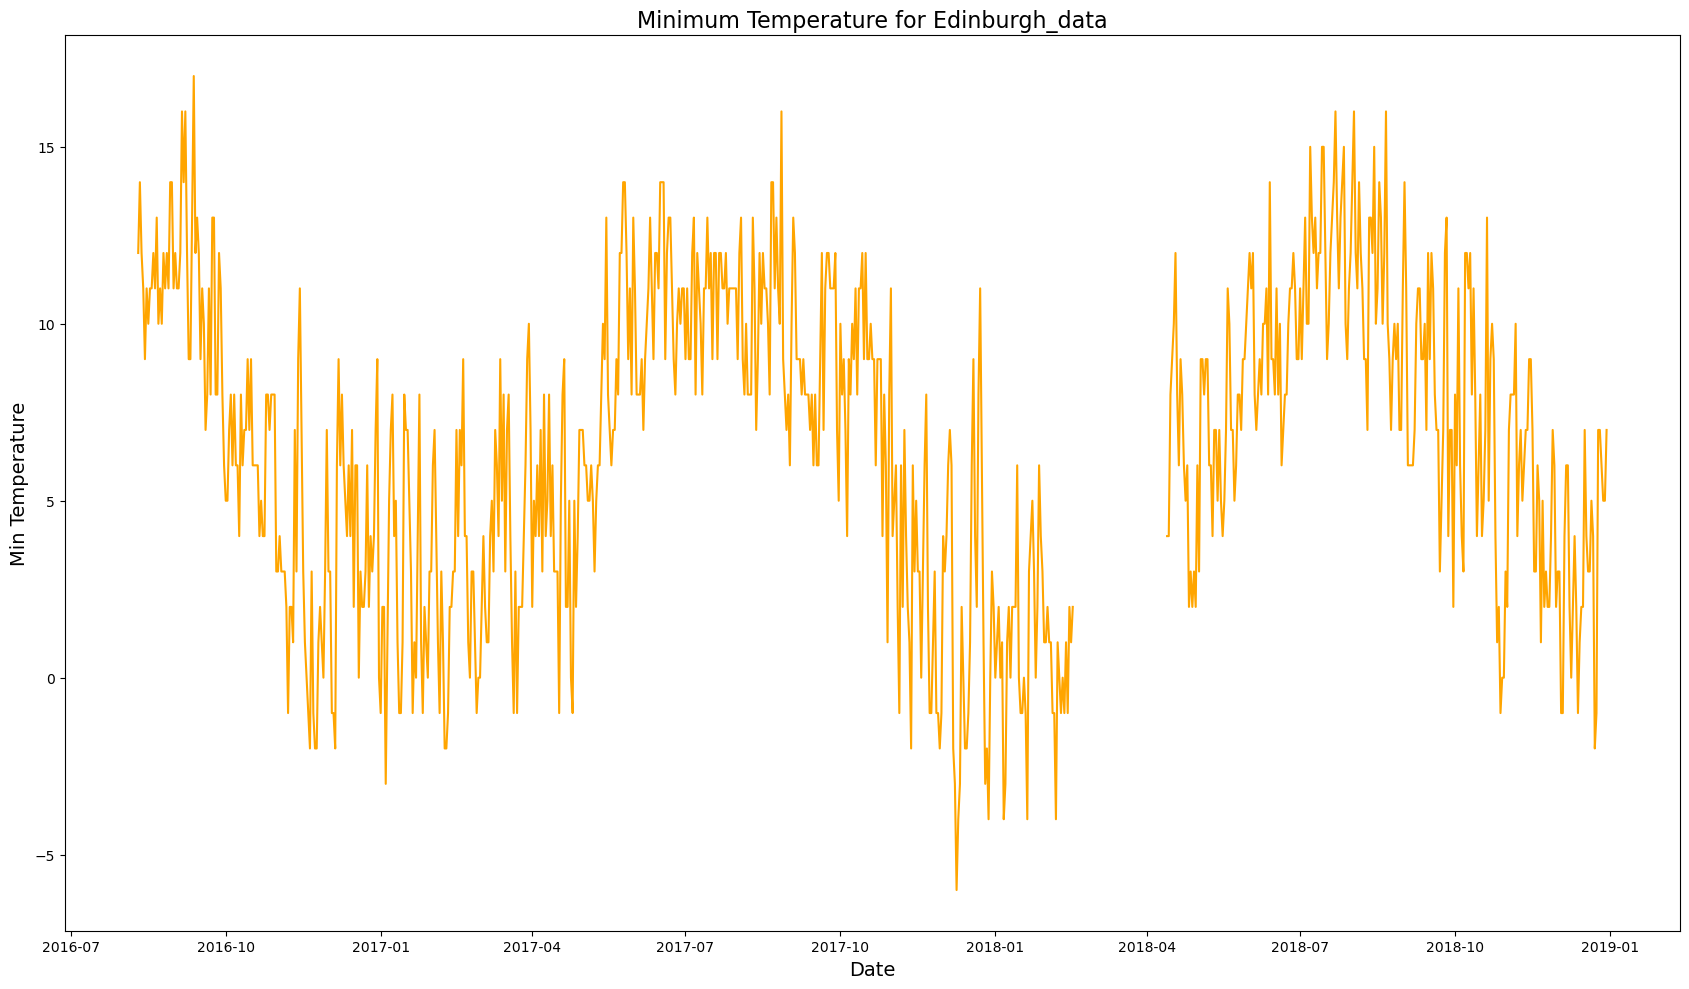

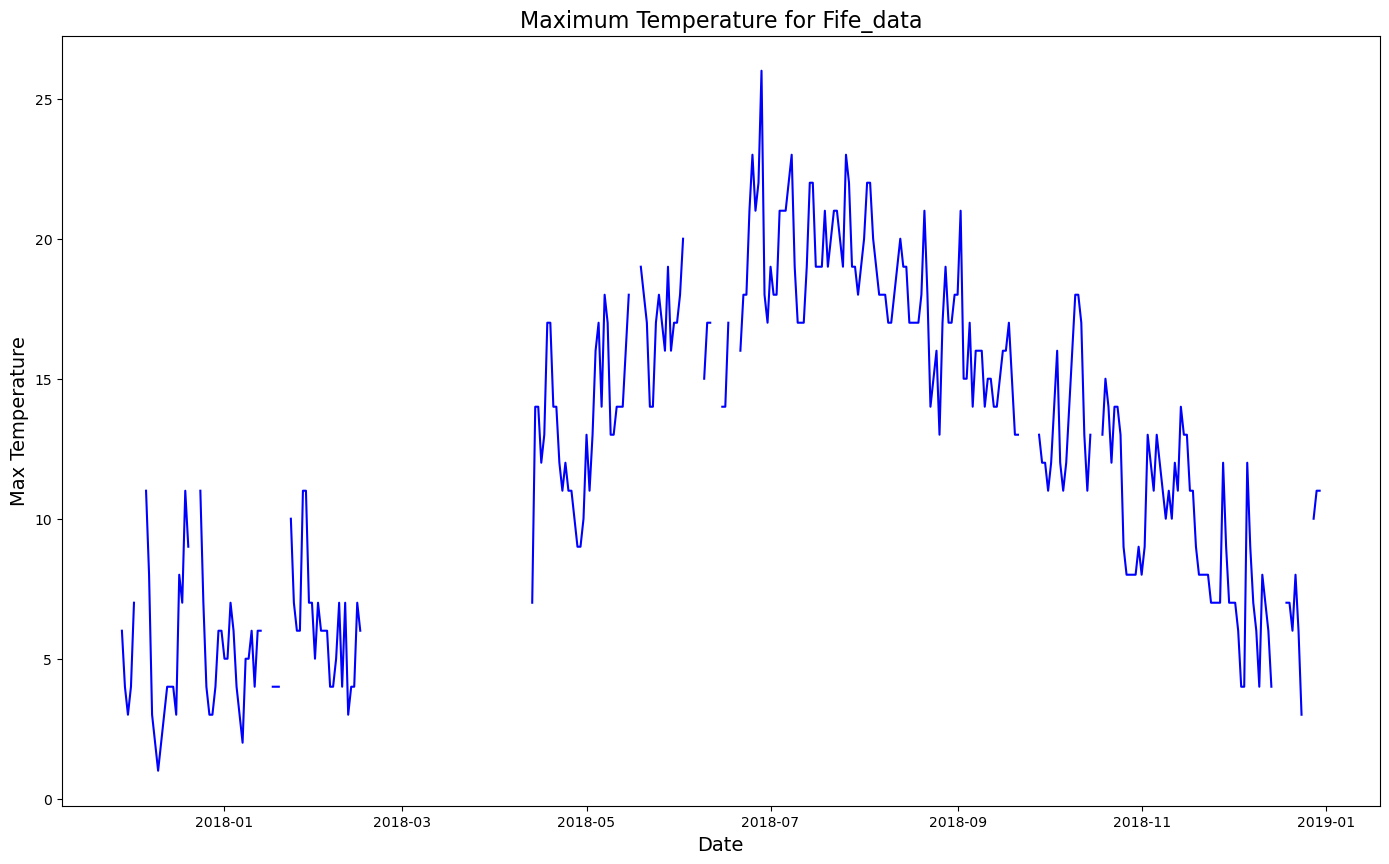

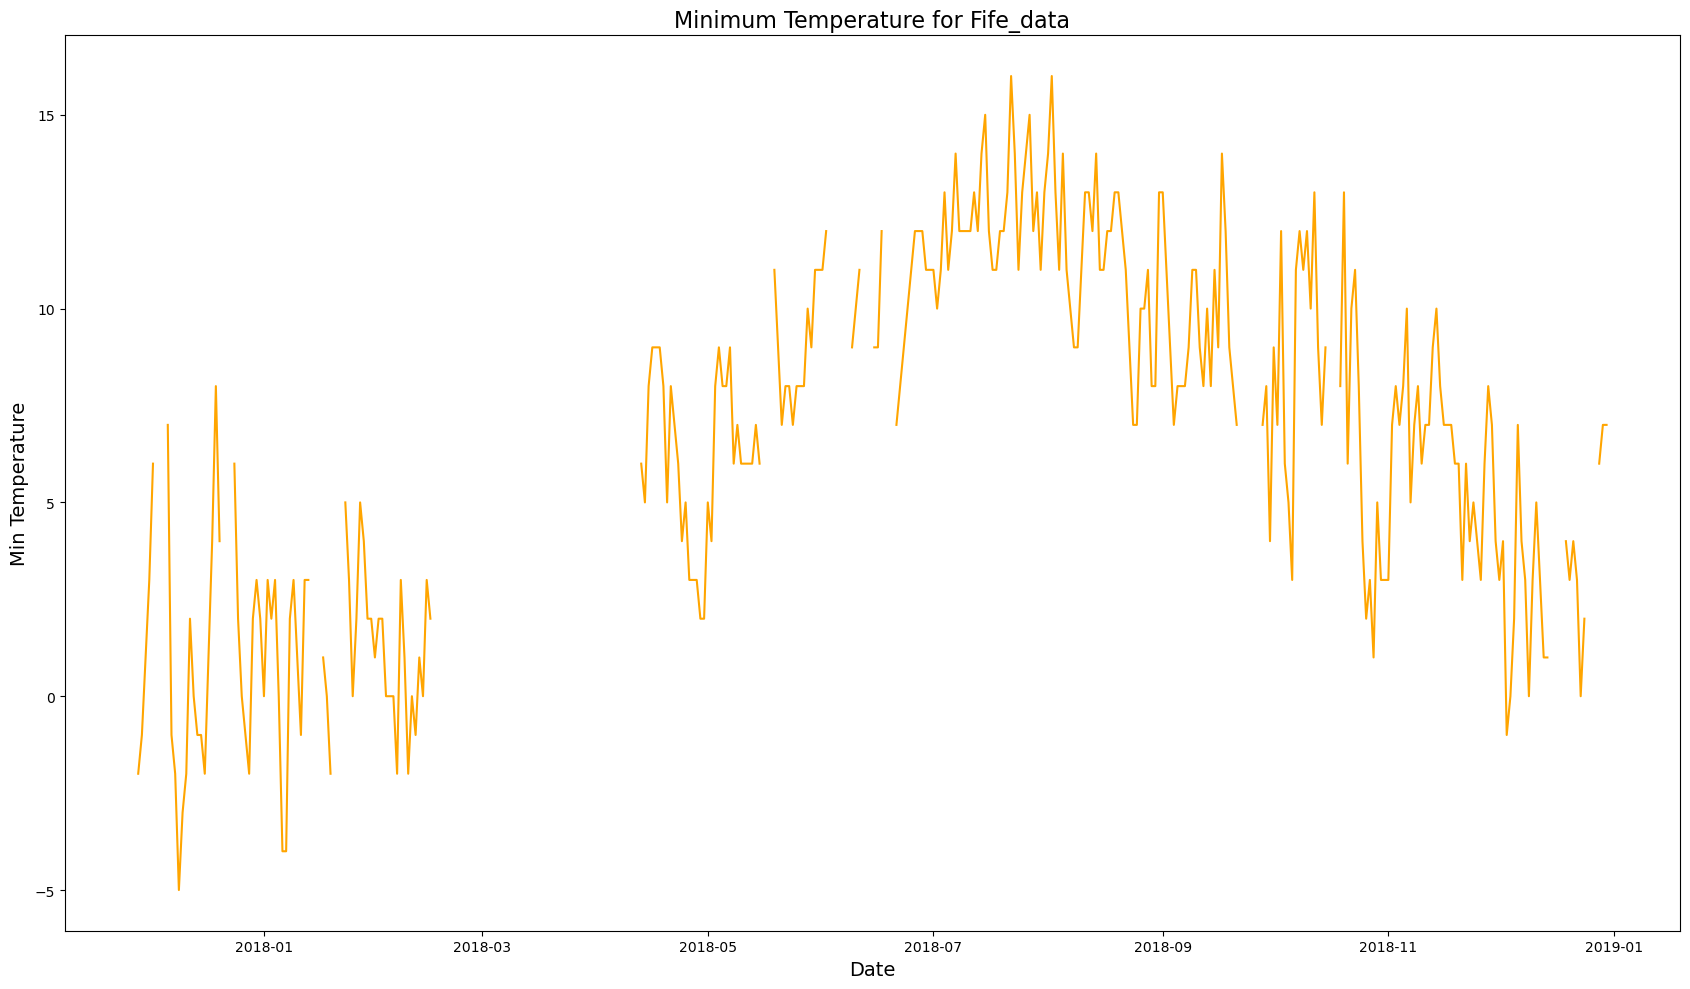

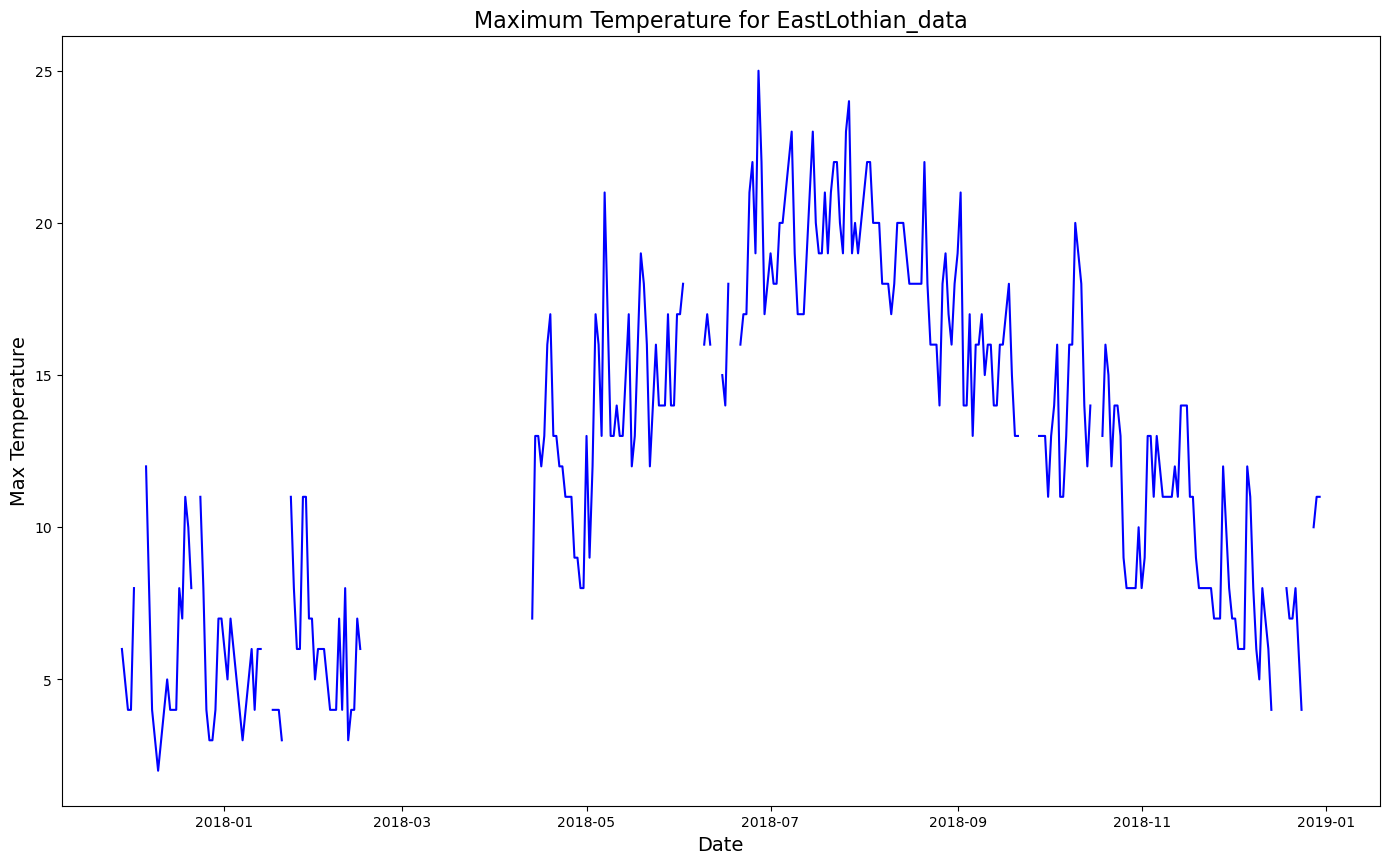

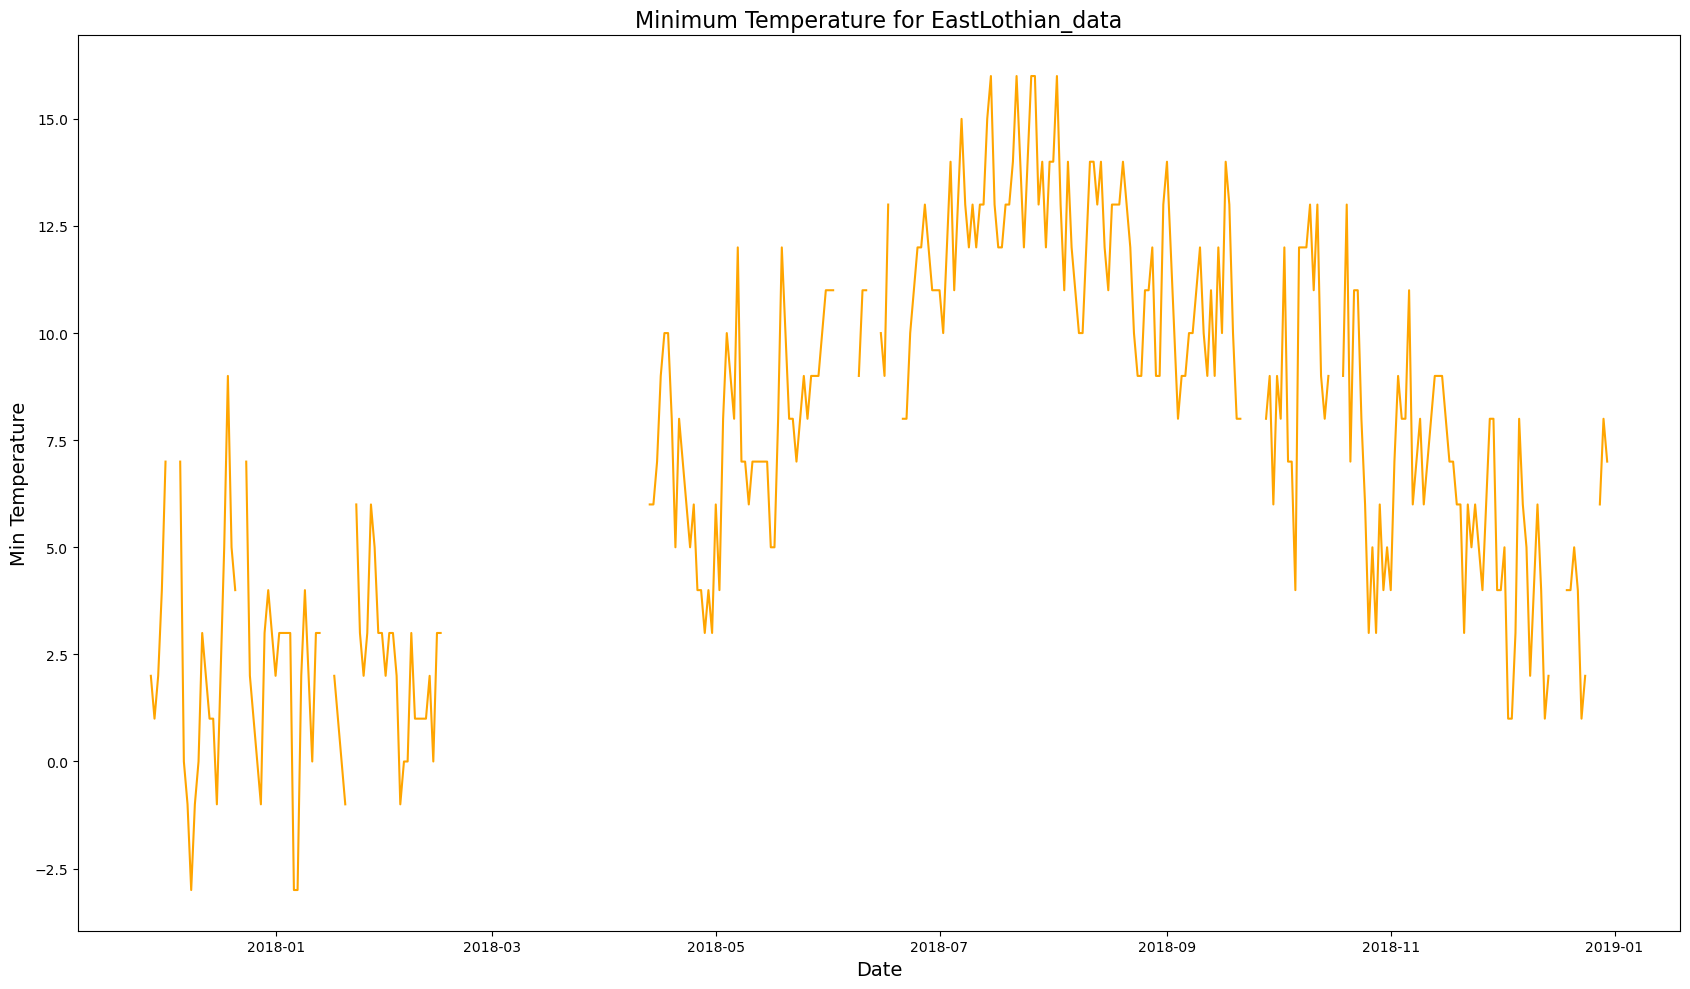

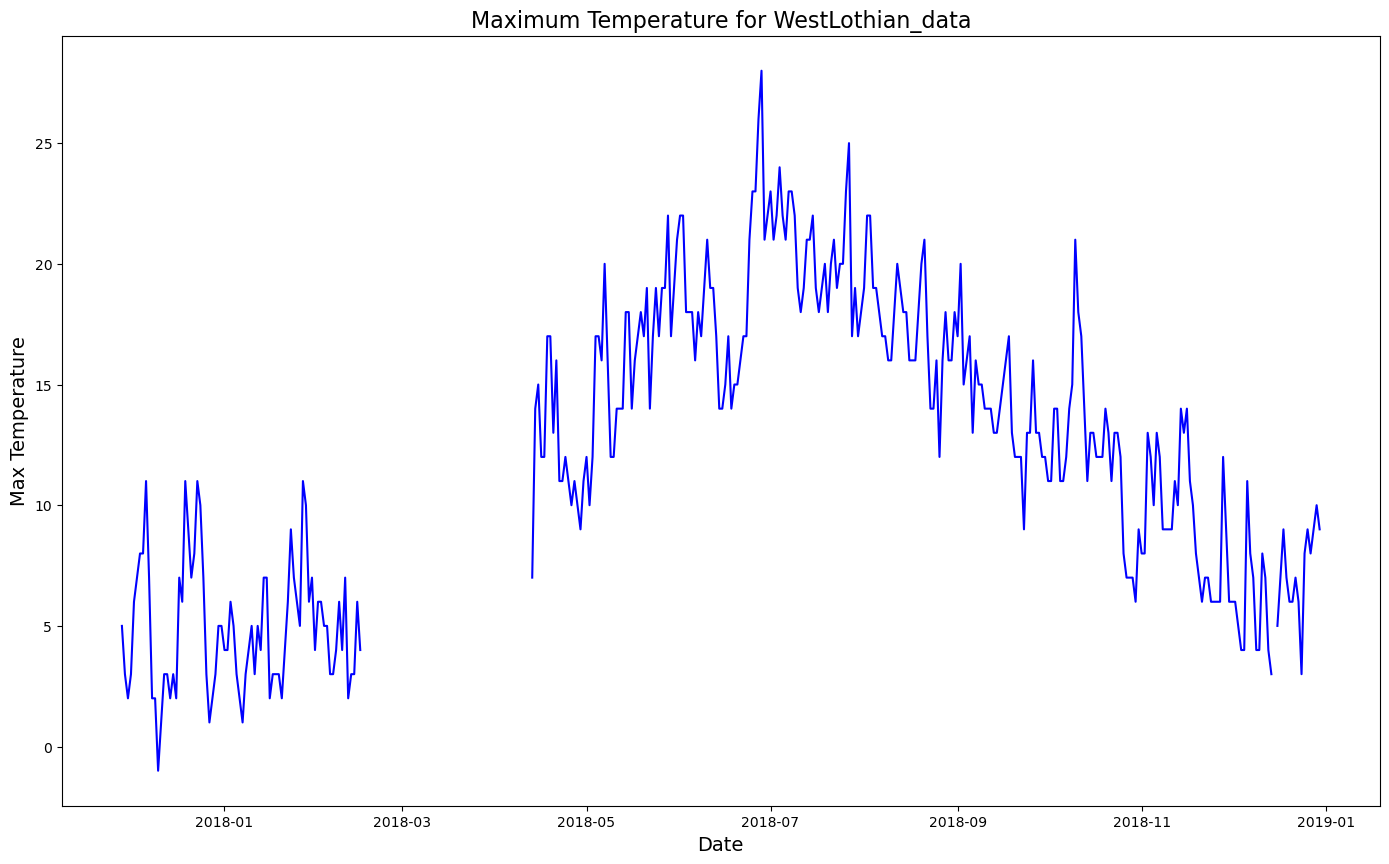

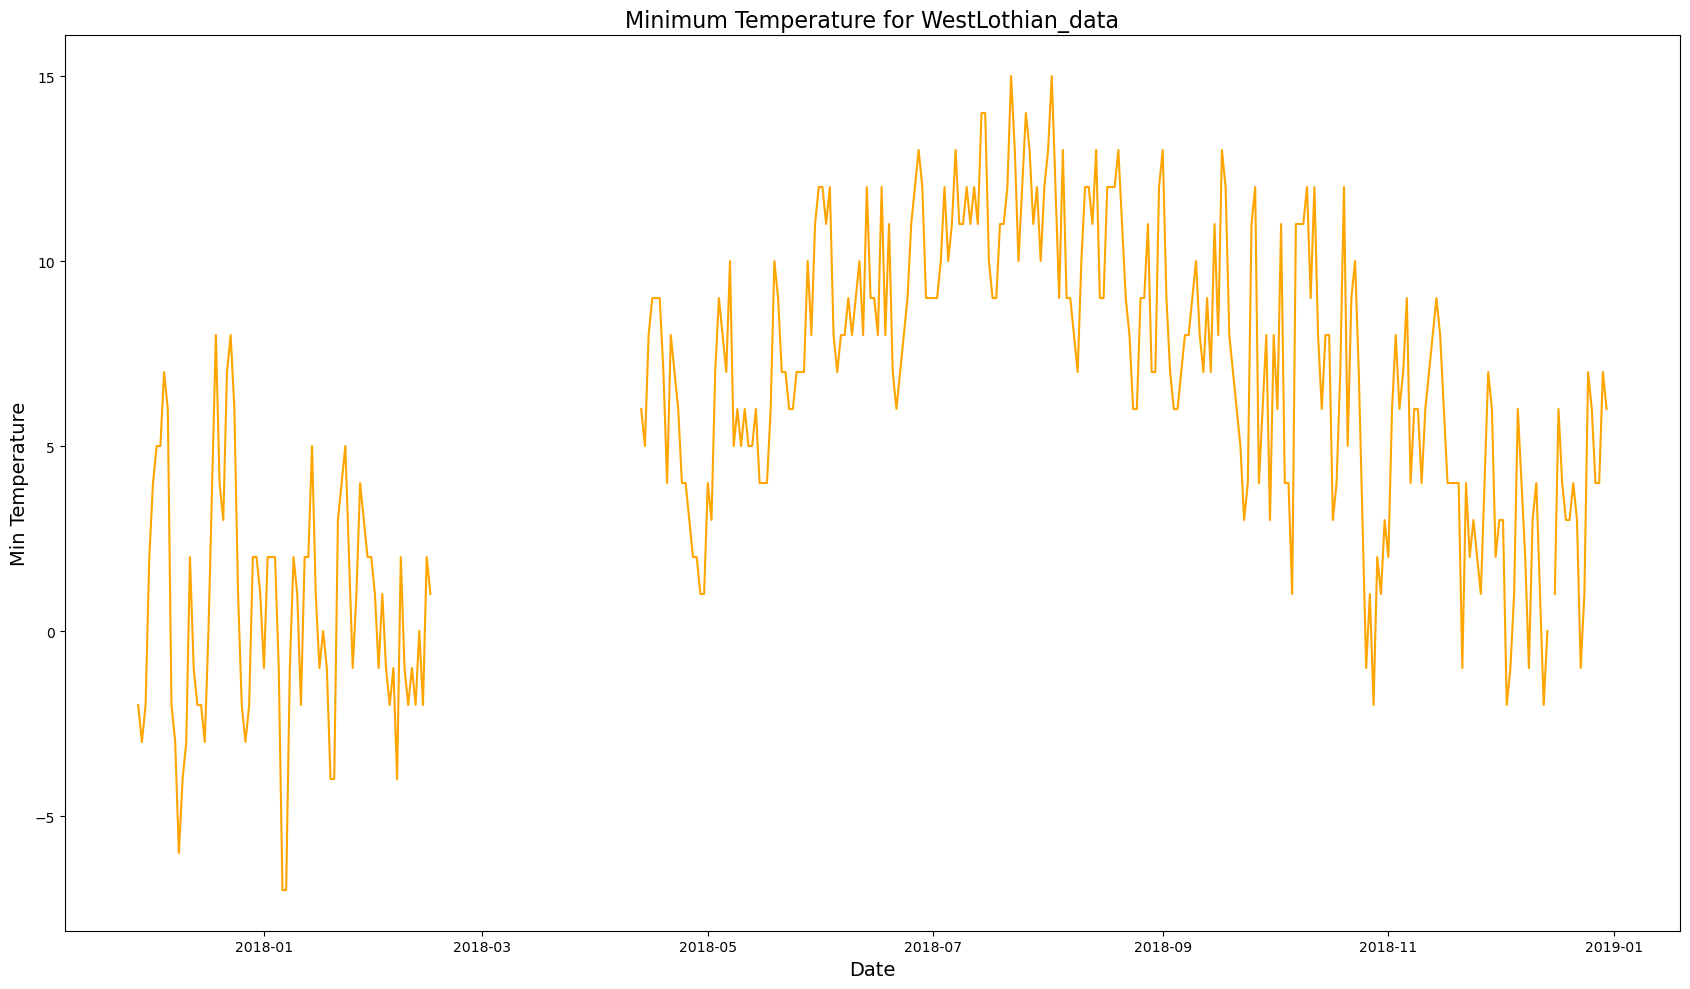

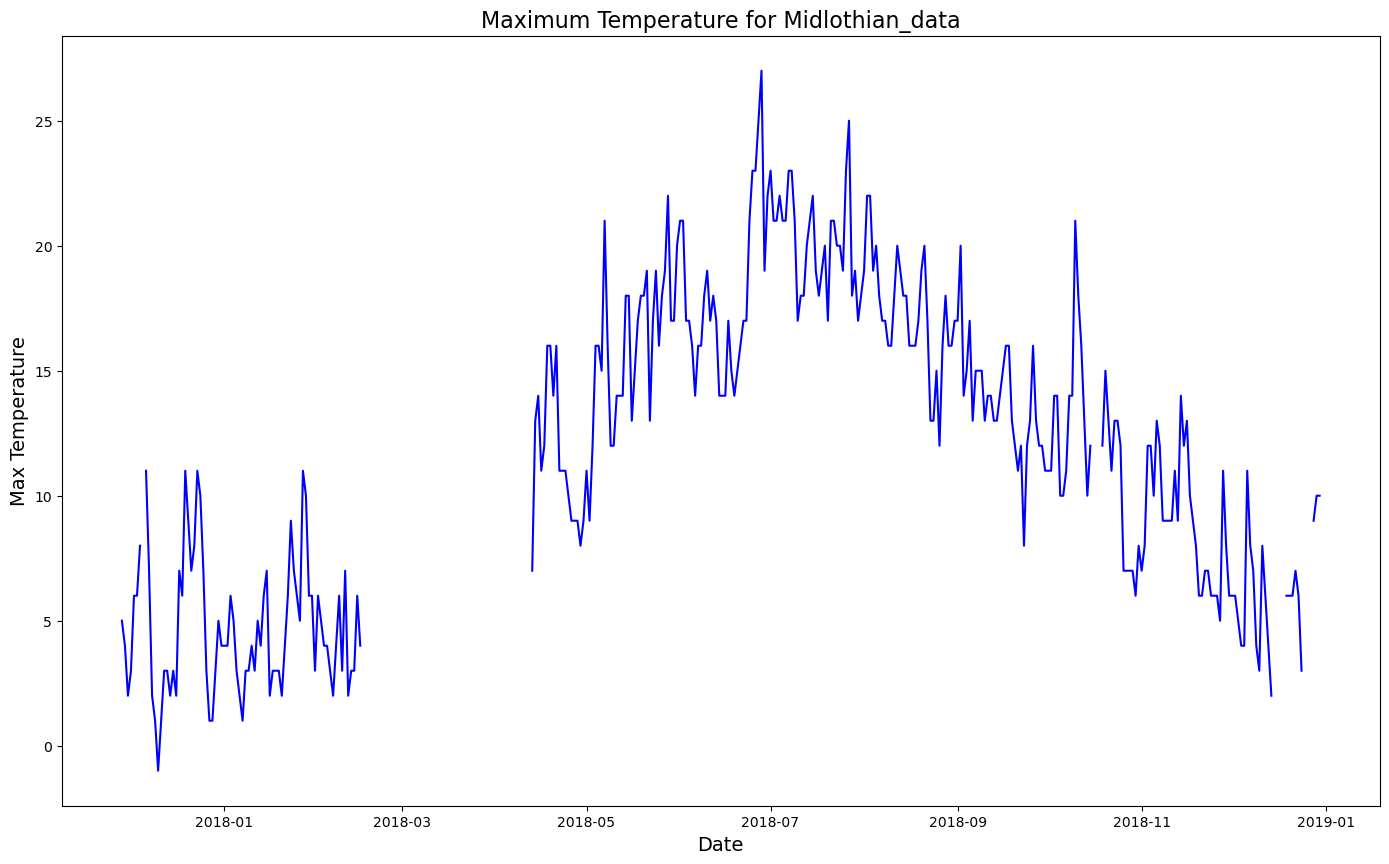

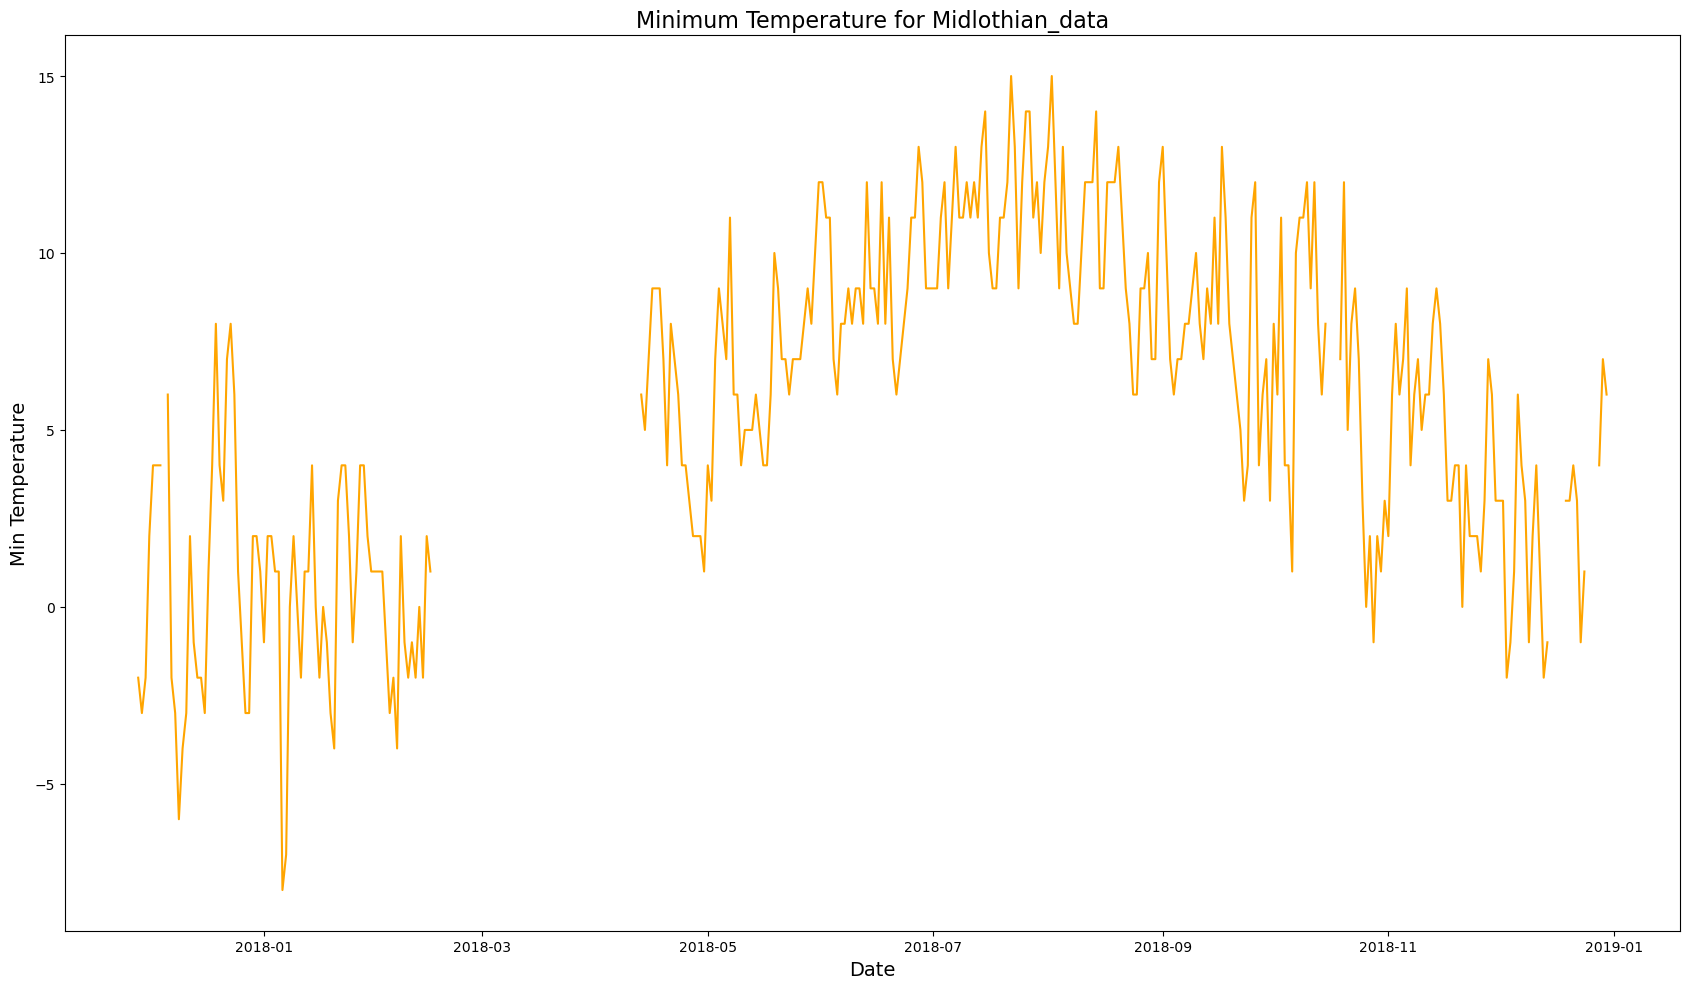

In [34]:
# Plot the time-series of min and max temp for each location
for loc, items in location_dataframes.items():
     globals()[f"{loc.lower()}"] = items.drop(columns=['locationid'])
     
for loc, items in location_dataframes.items():
     
    # Create a figure for max temperature
    fig, ax1 = plt.subplots(figsize=(17, 10))
    ax1.plot(items.index, items['maxtemp'], linestyle='-', color='blue')
    ax1.set_title(f"Maximum Temperature for {loc}", fontsize=16)
    ax1.set_xlabel("Date", fontsize=14)
    ax1.set_ylabel("Max Temperature", fontsize=14)

    # Create a figure for min temperature
    fig, ax2 = plt.subplots(figsize=(17, 10))
    ax2.plot(items.index, items['mintemp'], linestyle='-', color='orange')
    ax2.set_title(f"Minimum Temperature for {loc}", fontsize=16)
    ax2.set_xlabel("Date", fontsize=14)
    ax2.set_ylabel("Min Temperature", fontsize=14)

    plt.tight_layout() 
    plt.show()


##### 3.2.2 Functions to impute missing values for daily timestamps data

In [37]:
# function for fourier series
def fourier_series(x, *a):
    """General Fourier series function."""
    ret = a[0] / 2  # The constant term
    n_terms = (len(a) - 1) // 2
    for i in range(n_terms):
        ret += a[1 + i] * np.sin((i + 1) * x * 2 * np.pi / 365) + a[1 + n_terms + i] * np.cos((i + 1) * x * 2 * np.pi / 365)
    return ret

# function that uses the fourier series predictions on the observed data to calculate the residuals with the observed data and choose a random residual to add it in the predicted values to account for ups and downs
def add_residual_variation(predicted, residuals):
    """Add random residual noise to predicted values."""
    if len(residuals) > 0:
        noise = np.random.choice(residuals, size=len(predicted), replace=True)
        return predicted + noise
    return predicted


def impute_gaps(location_data, column_to_impute, small_gap_threshold=6, debug=False):
    # Ensure the index is datetime
    if not isinstance(location_data.index, pd.DatetimeIndex):
        location_data.index = pd.to_datetime(location_data.index)

    # Mark missing values for the specified column
    is_missing_col = f'is_missing_{column_to_impute}'
    gap_group_col = f'gap_group_{column_to_impute}'

    location_data[is_missing_col] = location_data[column_to_impute].isna()

    # Identify groups of consecutive missing values
    location_data[gap_group_col] = (
        location_data[is_missing_col] != location_data[is_missing_col].shift()  # keeps track of the previous row's record (shift) and allows the comparison with the current row to identify if the rows are in the same group (either True or False)
    ).cumsum() #  here cumsum accounts for the comparison --> if the comparison is True is means that we have a shift to a new group (cumsum increases) while if the comparison is false it means we are in the same group so the cumsum remains the same --> this way we group the rows based on the comparisons we did

    # Calculate the size of each gap group
    gap_sizes = location_data.groupby(gap_group_col).agg(
        is_missing=(is_missing_col, 'first'), # stores True or False in the is_missing column to determine if a missing gap starts or no
        gap_size=(is_missing_col, 'sum') 
    ).reset_index()

    if debug:
        print(f"Gap Sizes for {column_to_impute}:")
        print(gap_sizes)

    # Handle small gaps (≤ small_gap_threshold)
    small_gaps = gap_sizes[gap_sizes['is_missing'] & (gap_sizes['gap_size'] <= small_gap_threshold)]
    if debug:
        print(f"Identified small gaps (≤ {small_gap_threshold}): {len(small_gaps)}")

    for _, row in small_gaps.iterrows():
        gap_group = row[gap_group_col]
        gap_indices = location_data[location_data[gap_group_col] == gap_group].index
        if debug:
            print(f"Small gap group {gap_group} from {gap_indices[0]} to {gap_indices[-1]}")

        # Apply spline interpolation for small gaps
        location_data.loc[gap_indices, column_to_impute] = location_data[column_to_impute].interpolate(
            method='spline', order=3
        )

    # Handle large gaps (> small_gap_threshold)
    large_gaps = gap_sizes[gap_sizes['is_missing'] & (gap_sizes['gap_size'] > small_gap_threshold)]
    if debug:
        print(f"Identified large gaps (> {small_gap_threshold}): {len(large_gaps)}")

    for _, row in large_gaps.iterrows():
        gap_group = row[gap_group_col]
        gap_indices = location_data[location_data[gap_group_col] == gap_group].index
        gap_start = gap_indices[0]
        gap_end = gap_indices[-1]

        if debug:
            print(f"gap_start: {gap_start}, gap_end: {gap_end}")
            print(f"Data index type: {location_data.index}")

        try:
            # Extract available data (excluding missing values)
            available_data = location_data[~location_data[column_to_impute].isna()]
            x = (available_data.index - available_data.index[0]).days.values # transform dates in numerical format (by day)
            y = available_data[column_to_impute].values # extract the values of the existing data for the selected column

            # Fit a Fourier series
            n_harmonics = 3  # Number of harmonics to capture seasonal variation (determines how many sine and cosine functions are used to capture the seasonal variation)
            p0 = [np.mean(y)] + [0] * (2 * n_harmonics)  # Initial guess (necessary for the curve_fit function to start the optimisation)
            params, _ = curve_fit(fourier_series, x, y, p0=p0) # use the curve_fit to extract the optimal params for the Fourier Series that minimise the difference between the observed and the fourier predicted values (minimises the sum of square residuals)
            
            # Explanation of how we define harmonics (based on the visual representation of the data:
            # The first harmonic captures the broad seasonal cycle (e.g., summer to winter transitions).
            # The second harmonic refines this by accounting for mid-season shifts.
            # The third harmonic focuses on even smaller variations, like monthly changes or irregularities within seasons.
            # the more harmonics we add the more the detail but then the model is prone to overfitting
            
            #COSINE: It starts at a peak (1), dips to zero, drops to a trough (−1), returns to zero, and completes a cycle back at 1 ! better for long-term oscillations
            #SINE: It starts at zero, rises to a peak (1), falls to zero, dips to a trough (−1), and completes a cycle back at 0 ! better for mid-season oscillations since it starts from zero
            # Since there two together are orthogonal, they capture different variations
            

            
            # Calculate residuals for the 
            y_fit = fourier_series(x, *params) # params = a0, ak, bk. These represent the average level of the data (a0), the amplitude of the  k-term cosine (ak) and the amplitude of the k-th sine term (bk)
            residuals = y - y_fit

            # Predict for the gap indices
            x_pred = (gap_indices - available_data.index[0]).days.values # extract the dates in numerical format for the missing timestamps
            y_pred = fourier_series(x_pred, *params) # apply the fourier series to predict the missing gaps using the optimised params that were obtained from the fitted fourier model on the existing data

            # Add residual-based noise 
            y_pred_with_noise = add_residual_variation(y_pred, residuals) # we add to the predicted values of the missing gaps, a random noise that was obtained based on the residuals that were calculated between the predicted (from fourier series) and the observed data

            # Assign predicted values
            location_data.loc[gap_indices, column_to_impute] = y_pred_with_noise

            if debug:
                print(f"Fourier series imputed values with noise for gap group {gap_group}:")
                print(y_pred_with_noise)

        except Exception as e:
            if debug:
                print(f"Fourier series failed for gap group {gap_group}: {e}")
            # Fallback to KNN
            print(f"Fallback to KNN for gap group {gap_group}.")
            knn_imputer = KNNImputer(n_neighbors=3)
            location_data[column_to_impute] = knn_imputer.fit_transform(
                location_data[[column_to_impute]]
            ).flatten()

    # Drop temporary columns specific to the current imputation
    location_data.drop(columns=[is_missing_col, gap_group_col], inplace=True)

    # Final debugging
    if debug:
        print(f"Final missing values after imputation for {column_to_impute}: {location_data[column_to_impute].isna().sum()}")

    return location_data



# Apply imputation for each location
for loc, data in location_dataframes.items():
    print(f"Processing location: {loc}")
    
    # Impute 'mintemp'
    location_dataframes[loc] = impute_gaps(data, column_to_impute='mintemp', debug=True)
    print(f"Processed missing data for mintemp for location: {loc}")

    # Impute 'maxtemp'
    location_dataframes[loc] = impute_gaps(location_dataframes[loc], column_to_impute='maxtemp', debug=True)
    print(f"Processed missing data for maxtemp for location: {loc}")


Processing location: Edinburgh_data
Gap Sizes for mintemp:
   gap_group_mintemp  is_missing  gap_size
0                  1       False         0
1                  2        True        55
2                  3       False         0
Identified small gaps (≤ 6): 0
Identified large gaps (> 6): 1
gap_start: 2018-02-17 00:00:00, gap_end: 2018-04-12 00:00:00
Data index type: DatetimeIndex(['2016-08-10', '2016-08-11', '2016-08-12', '2016-08-13',
               '2016-08-14', '2016-08-15', '2016-08-16', '2016-08-17',
               '2016-08-18', '2016-08-19',
               ...
               '2018-12-21', '2018-12-22', '2018-12-23', '2018-12-24',
               '2018-12-25', '2018-12-26', '2018-12-27', '2018-12-28',
               '2018-12-29', '2018-12-30'],
              dtype='datetime64[ns]', name='date', length=873, freq=None)
Fourier series imputed values with noise for gap group 2:
[ 2.70423739 -2.388163    0.44423946  1.0440415   7.14582672  3.50104903
  2.54057401  5.66705415  9.882614

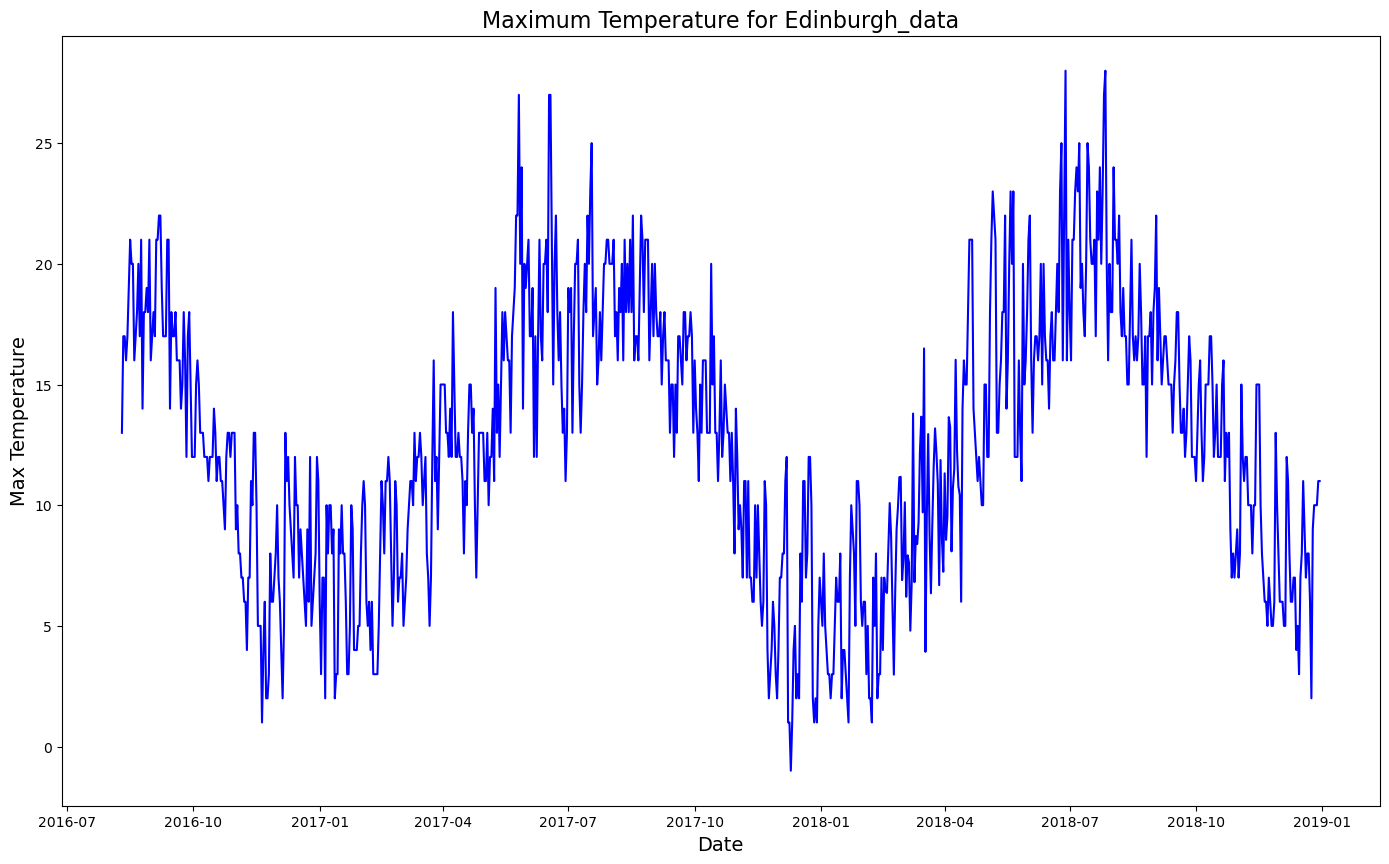

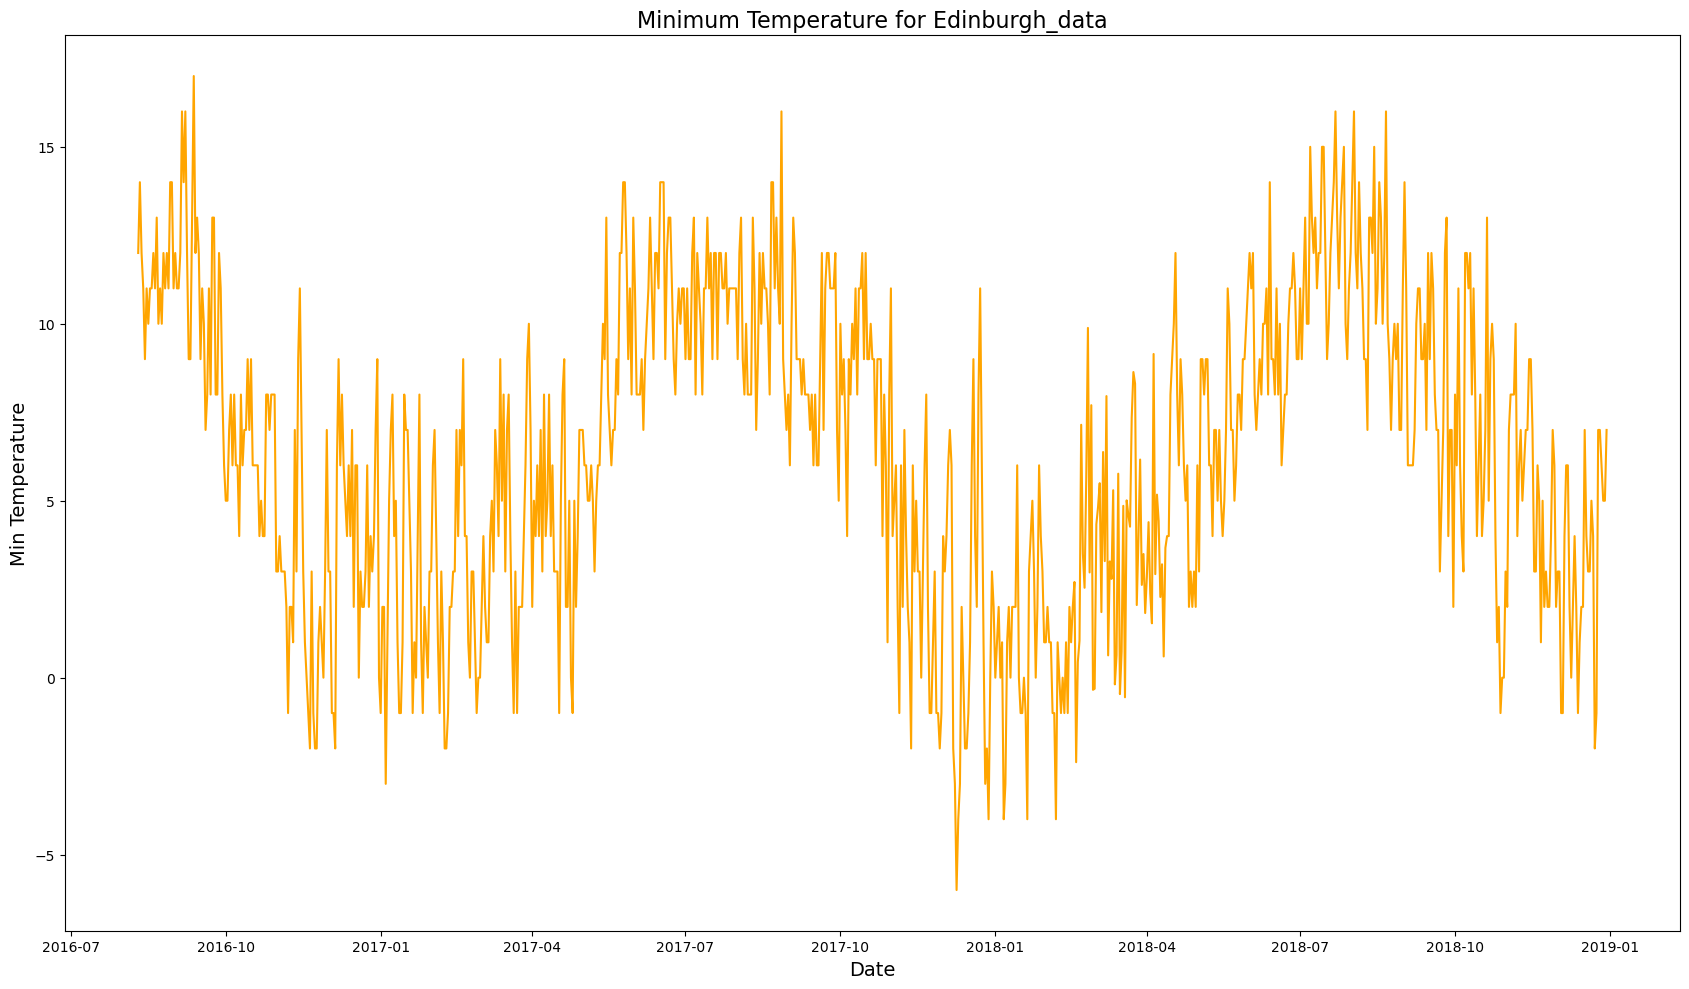

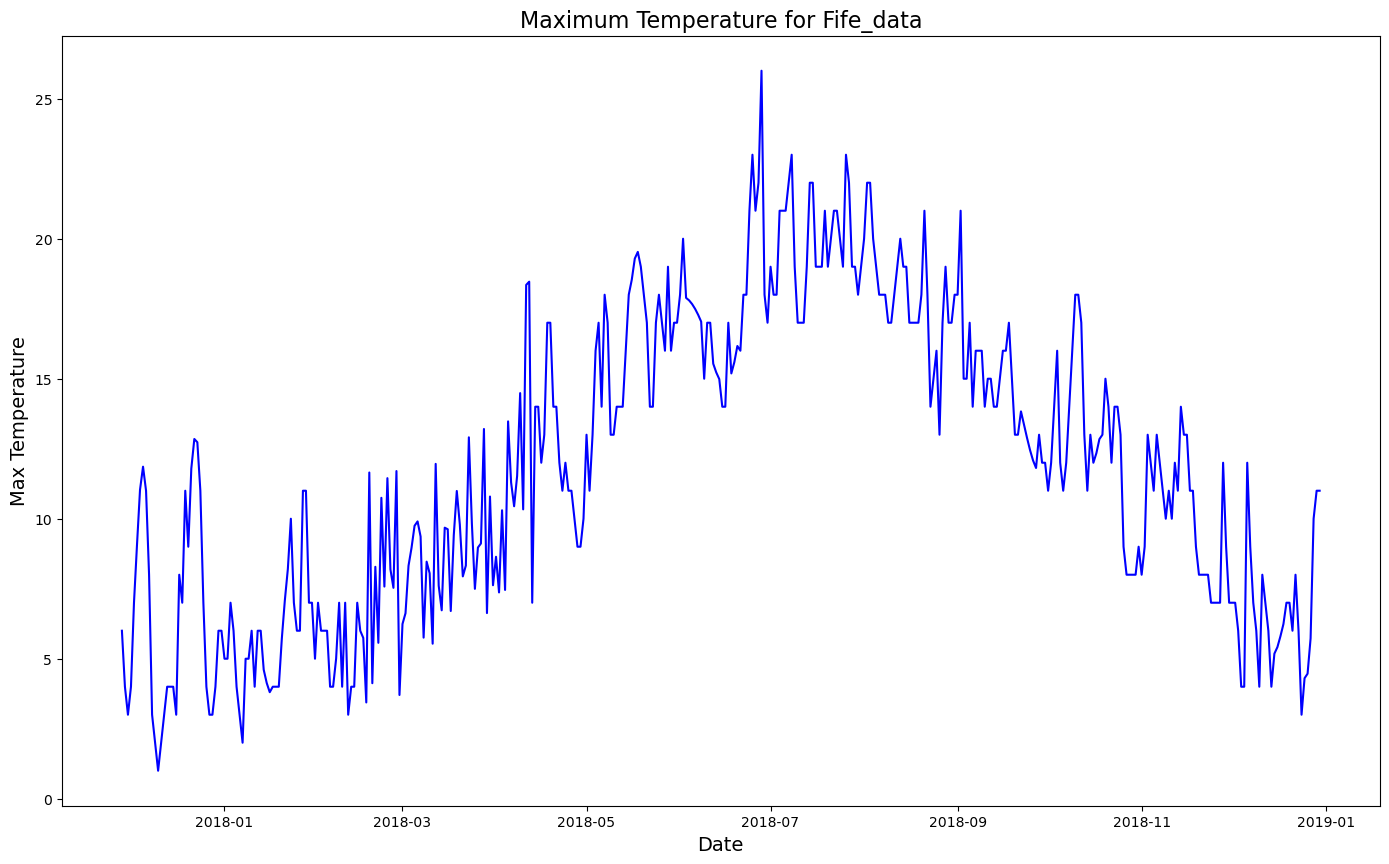

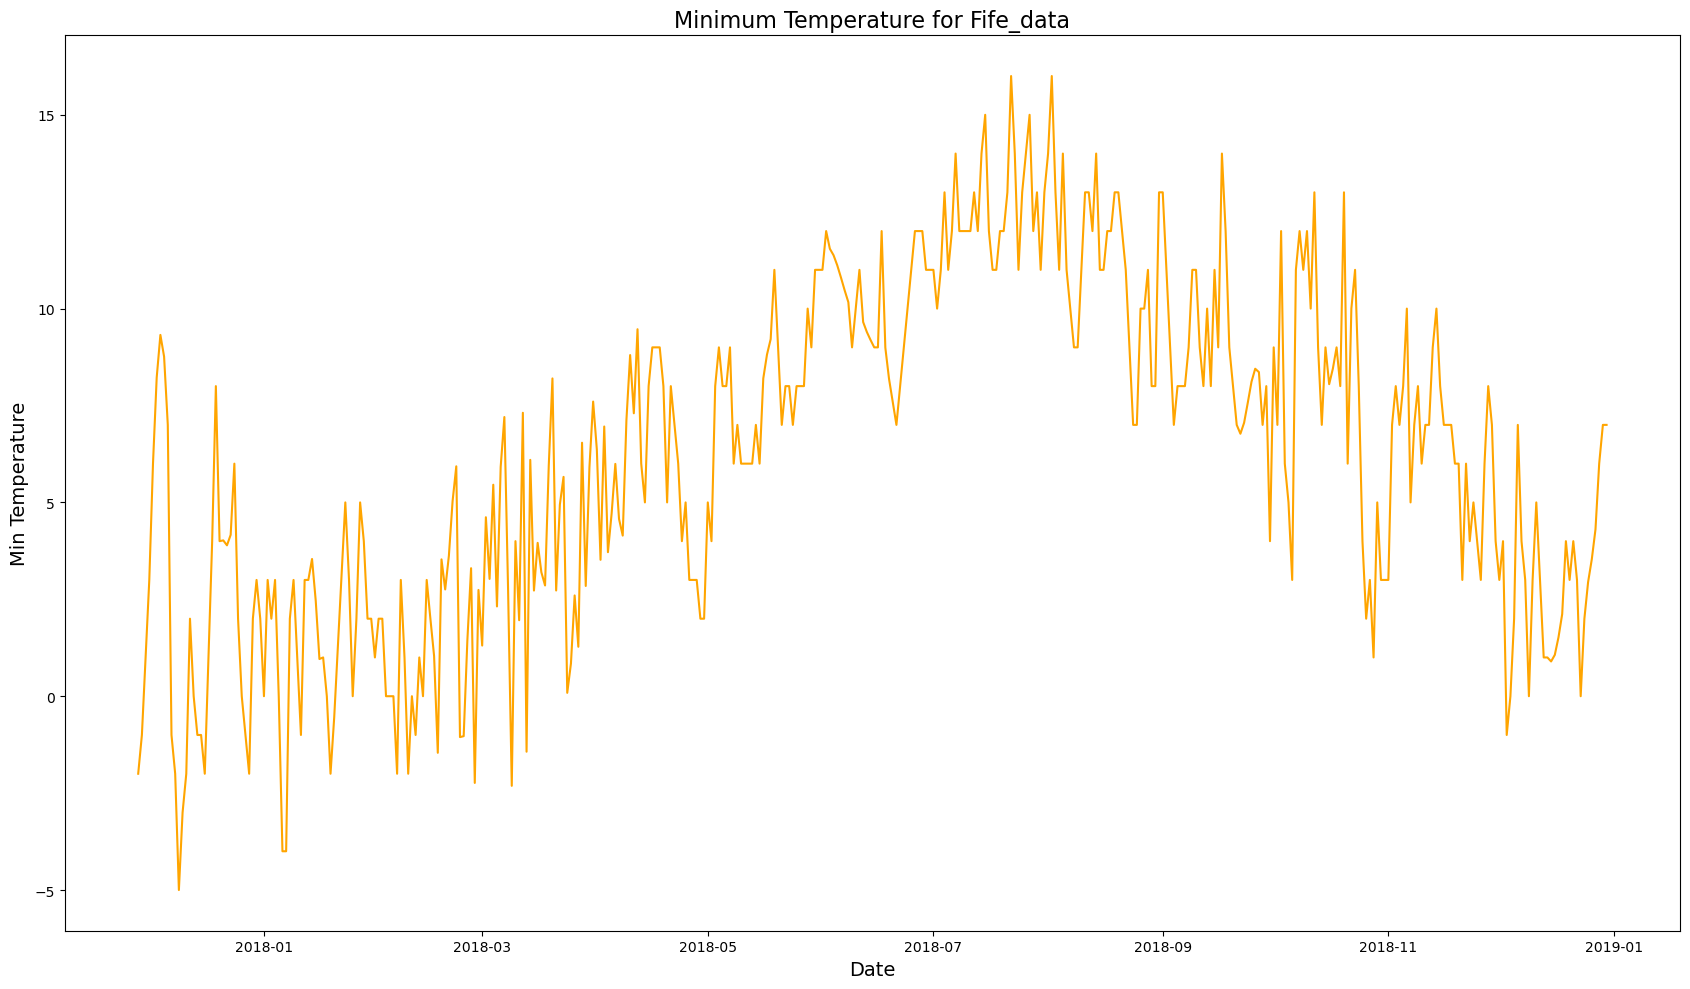

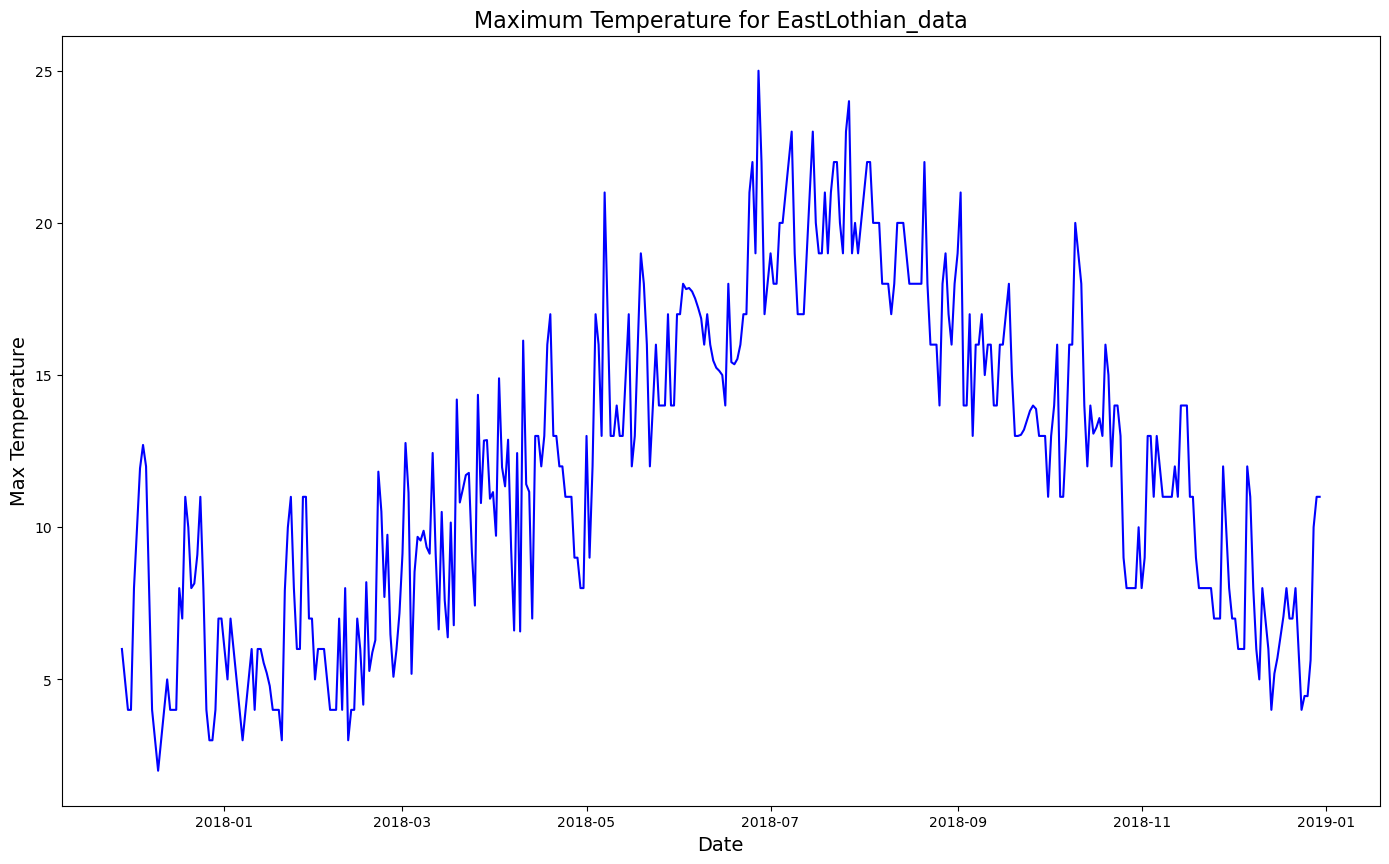

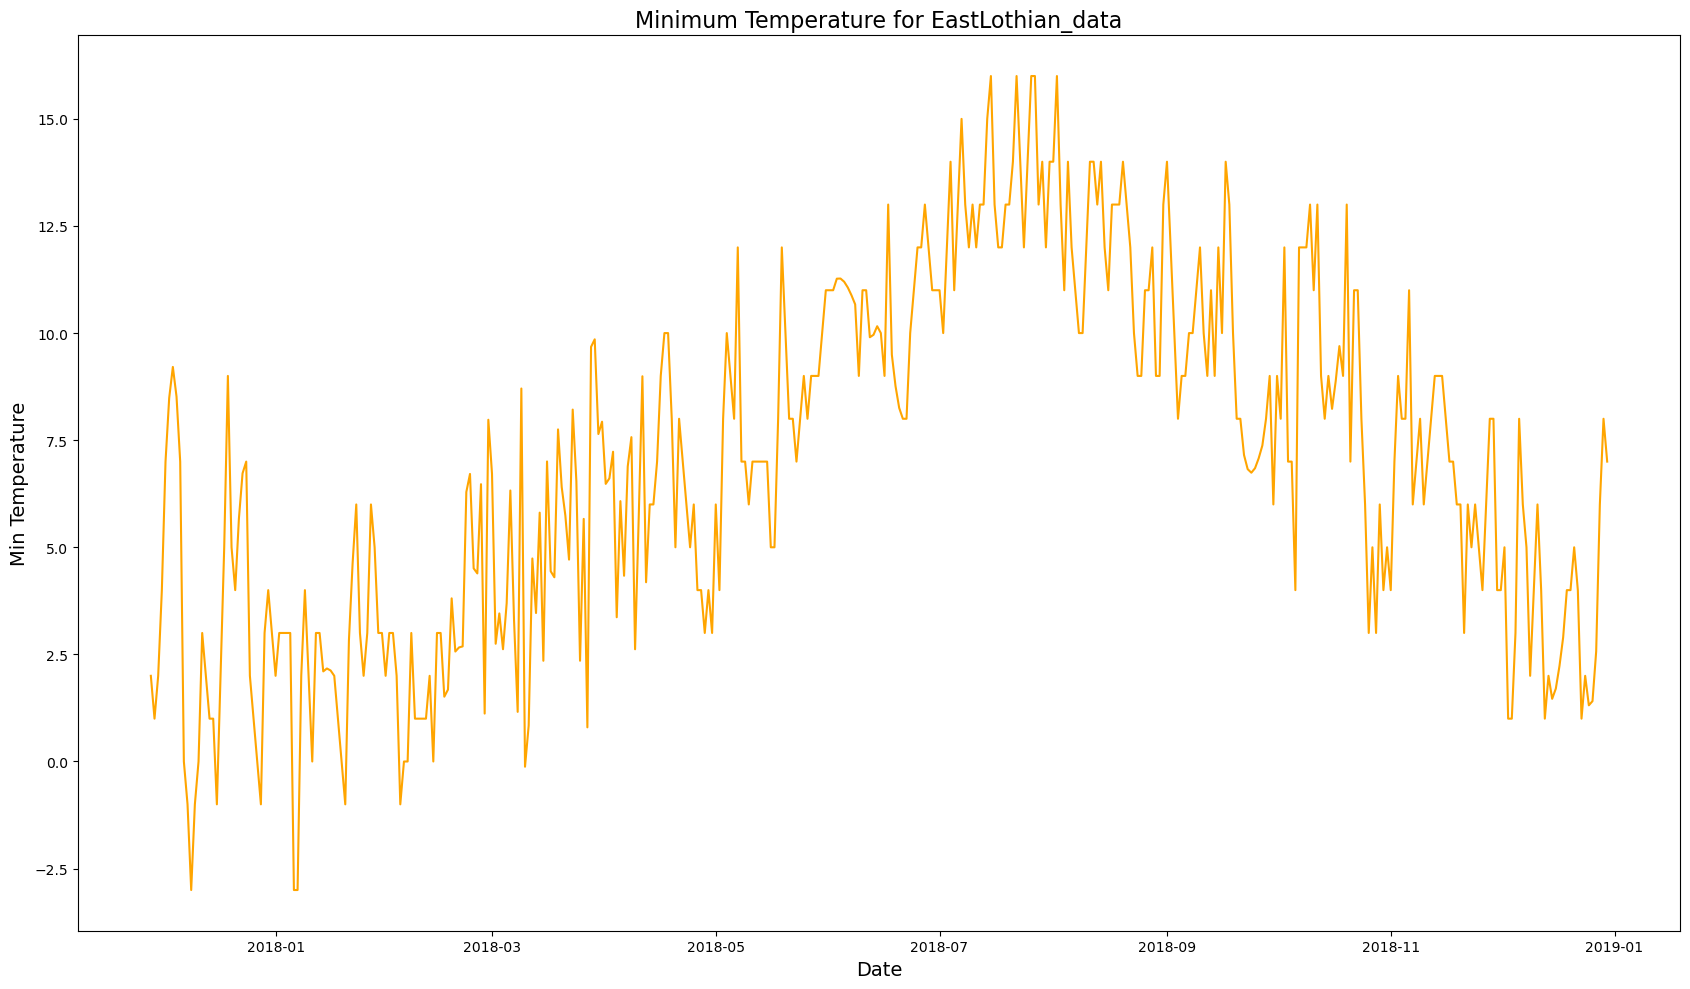

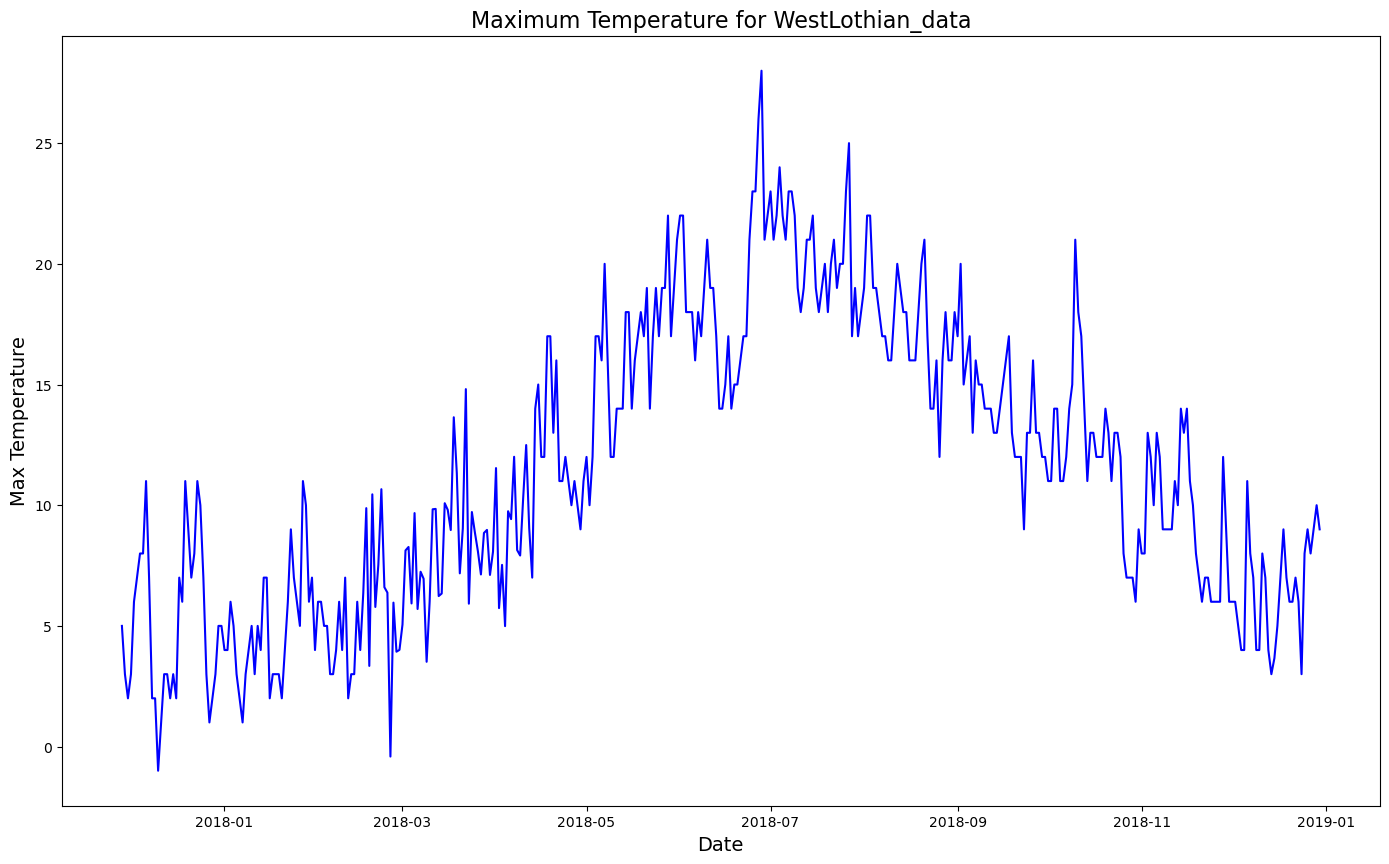

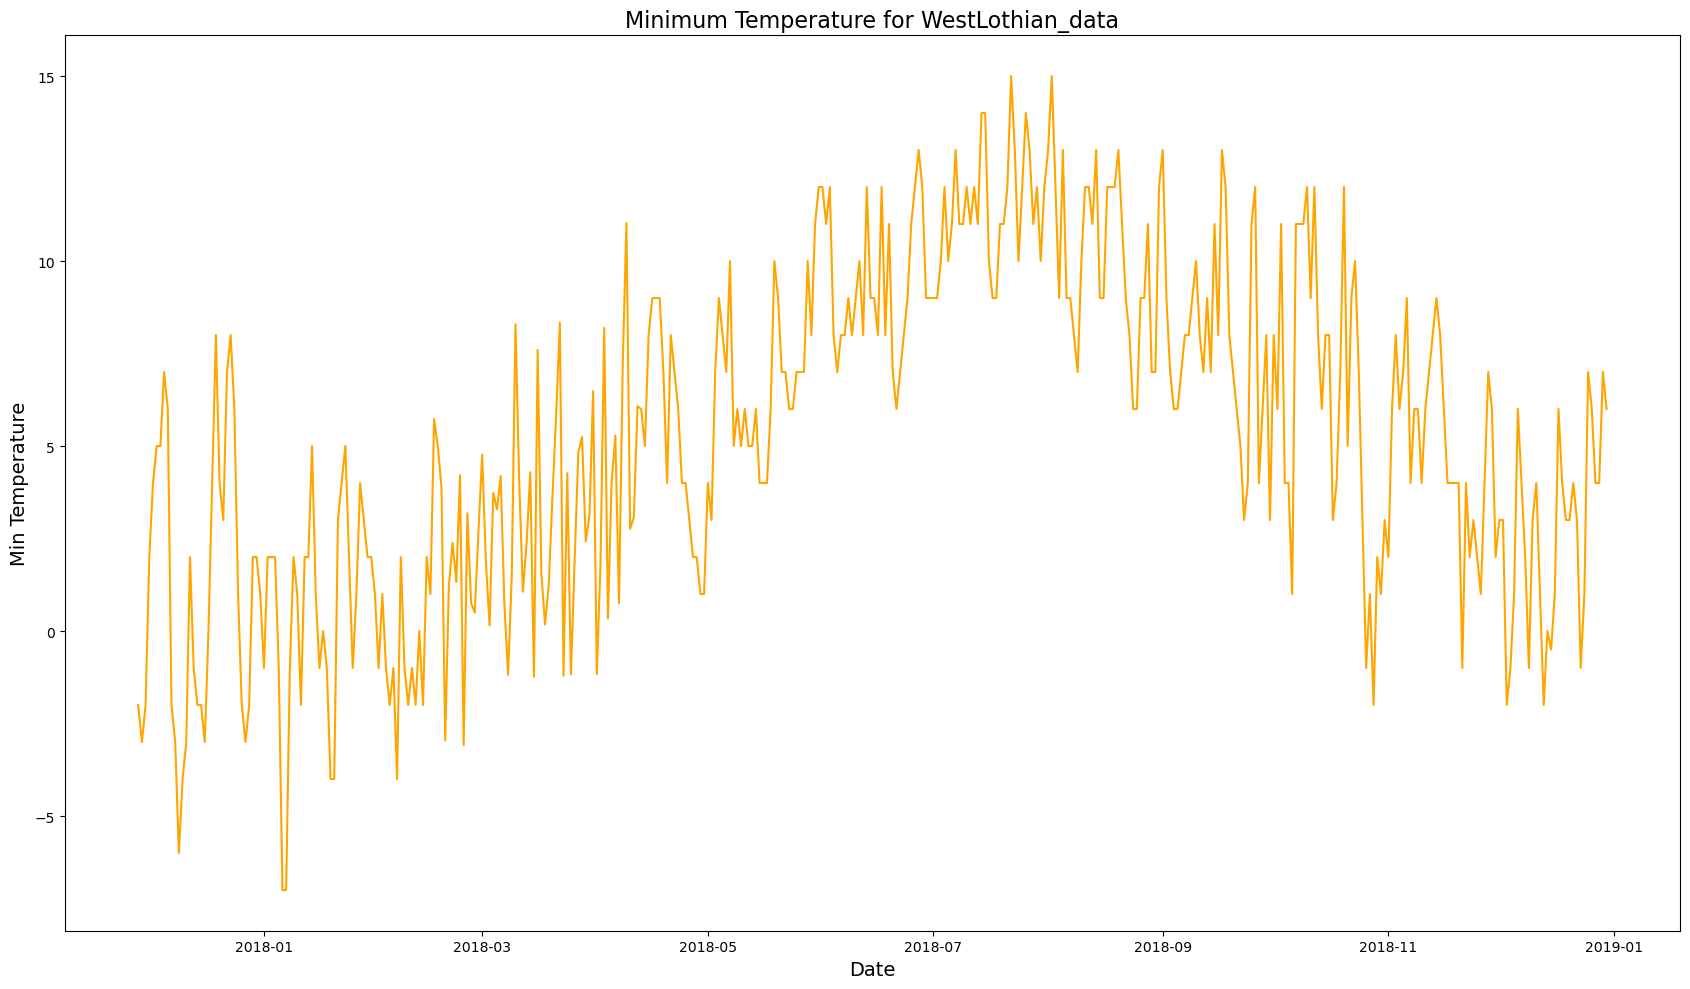

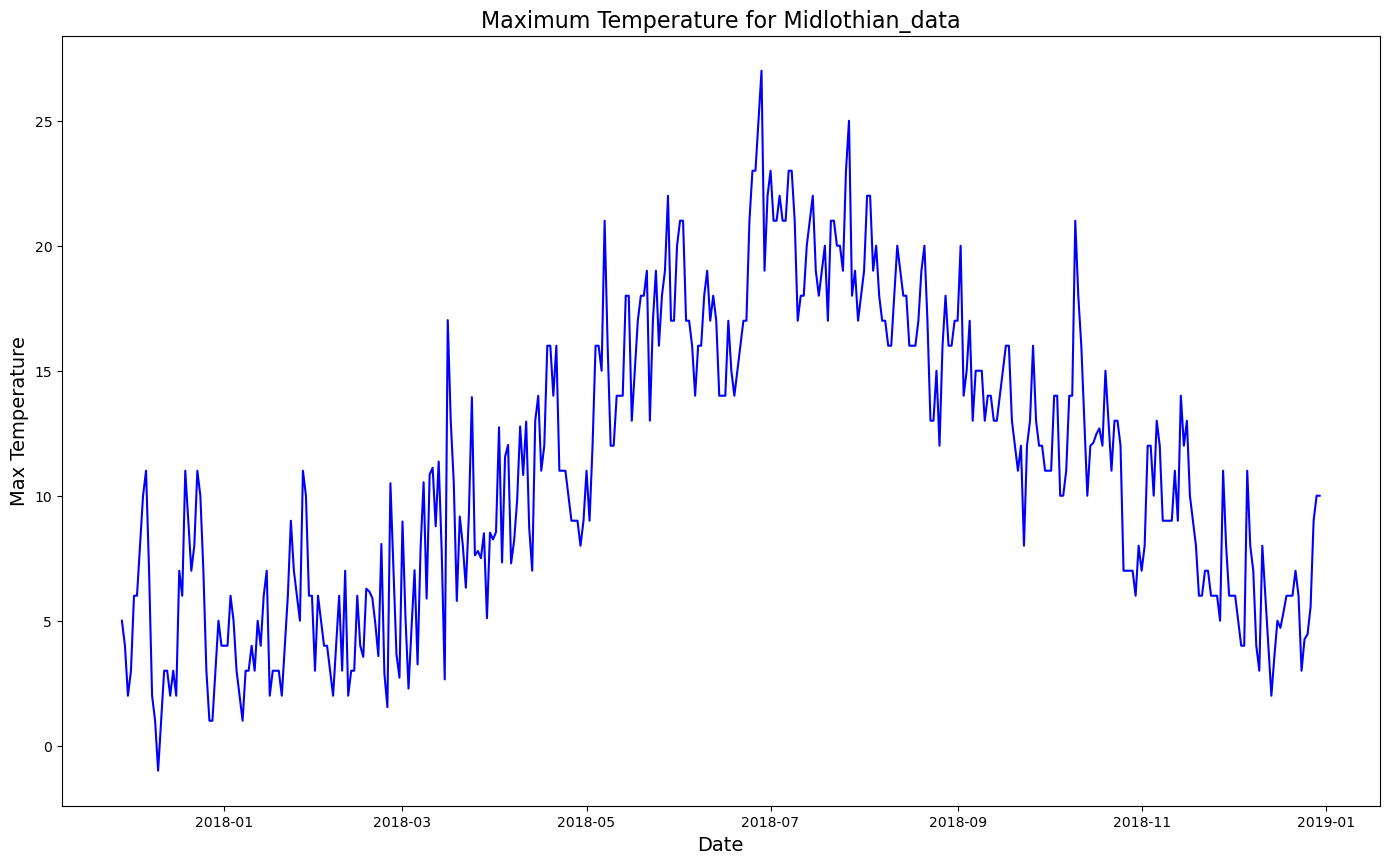

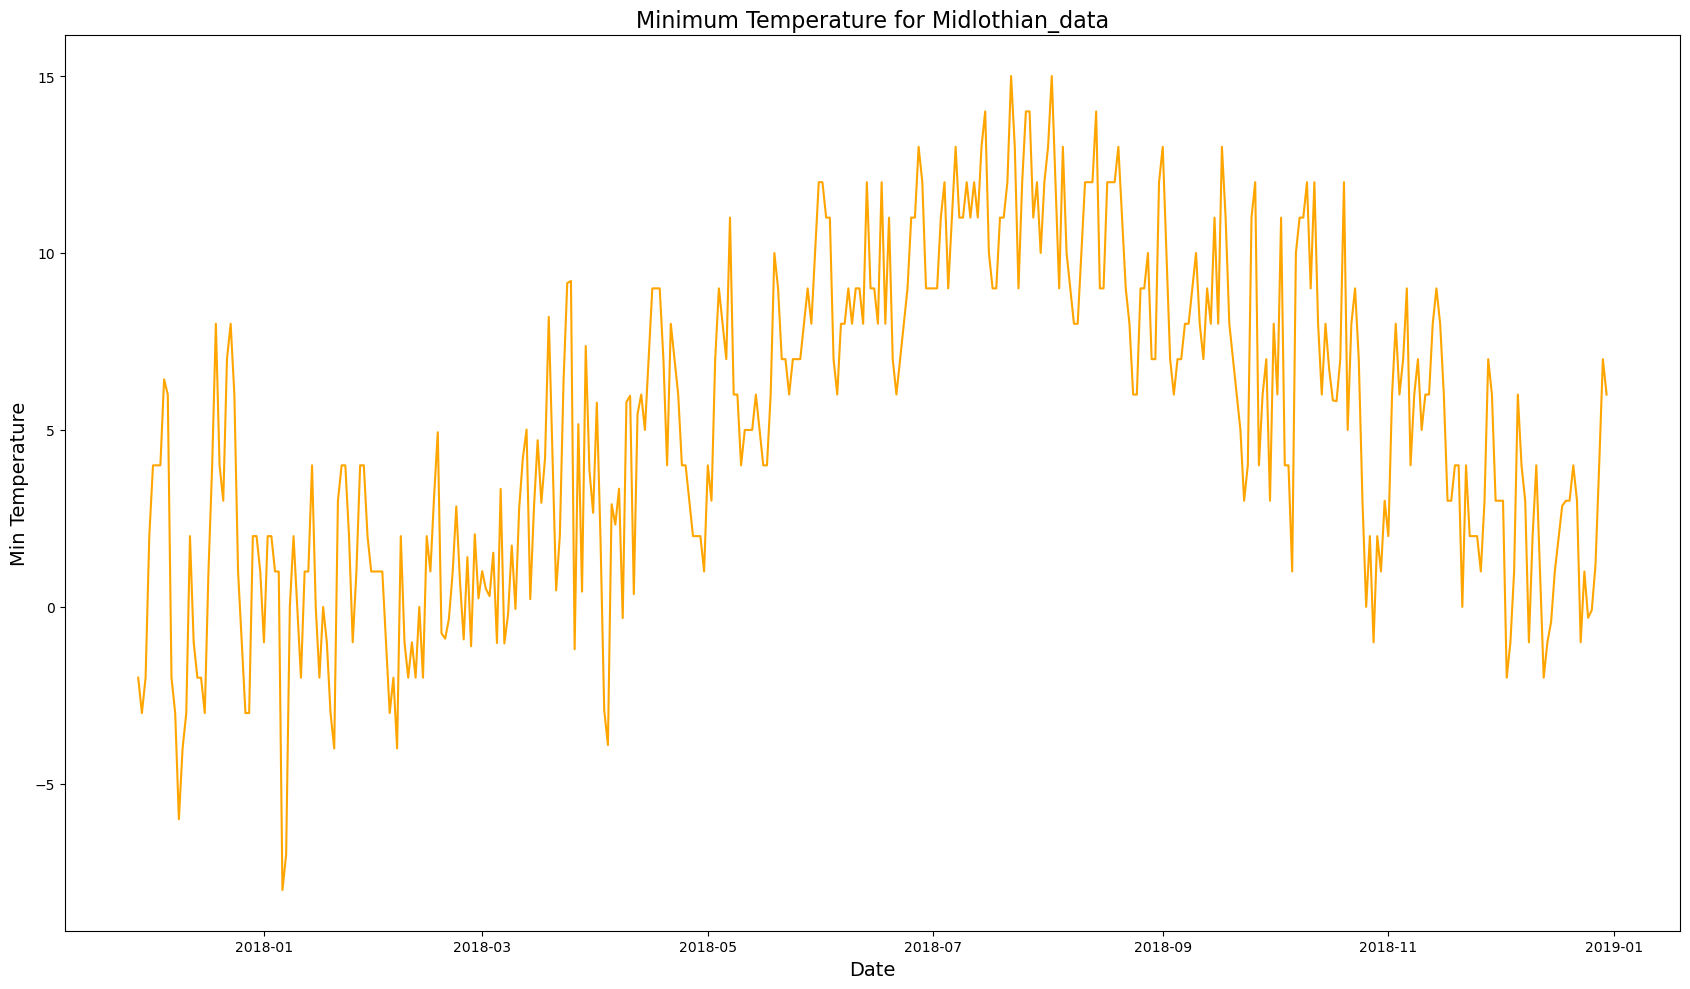

In [38]:
# Plot the imputed min and max temp by location
for loc, items in location_dataframes.items():
     
    # Create a figure for max temperature
    fig, ax1 = plt.subplots(figsize=(17, 10))
    ax1.plot(items.index, items['maxtemp'], linestyle='-', color='blue')
    ax1.set_title(f"Maximum Temperature for {loc}", fontsize=16)
    ax1.set_xlabel("Date", fontsize=14)
    ax1.set_ylabel("Max Temperature", fontsize=14)

    # Create a figure for min temperature
    fig, ax2 = plt.subplots(figsize=(17, 10))
    ax2.plot(items.index, items['mintemp'], linestyle='-', color='orange')
    ax2.set_title(f"Minimum Temperature for {loc}", fontsize=16)
    ax2.set_xlabel("Date", fontsize=14)
    ax2.set_ylabel("Min Temperature", fontsize=14)

    plt.tight_layout() 
    plt.show()

#### 3.3 Build hourly observations for min and max temp for each location (separately)

##### 3.3.1 Calculate hourly timestamps for each location based on their min and max timestamp

In [39]:
def hourly_timestamps_for_each_location(location):
    hourly_timestamps = pd.date_range(start=location_dataframes[location].index.strftime('%Y-%m-%d').min(),
                                    end =location_dataframes[location].index.strftime('%Y-%m-%d').max(),
                                    freq='H')

    hourly_timestamps = pd.to_datetime(hourly_timestamps)
    hourly_timestamps = pd.DataFrame(hourly_timestamps, columns=['timestamp']) 
    
    return hourly_timestamps

hourly_timestamps_by_location = {}

for location in location_dataframes.keys():
    hourly_timestamps_by_location[f'{location}_hourly_timestamps'] = hourly_timestamps_for_each_location(location)

##### 3.3.2 Estimate the hourly min and max temp for each location (sine function)

In [40]:
def hourly_temps_estimation(mintemp, maxtemp):
    avg_temp = np.mean([mintemp, maxtemp])
    amplitude = (np.ptp([mintemp, maxtemp]))/2
    
    t_min = 5
    hourly_temps = []
    
    for hour in range(24):
        temp = avg_temp + amplitude * (np.sin((2 * np.pi * (hour-t_min))/24 - (5 * np.pi / 12)))
        
        hourly_temps.append(temp)
    
    return hourly_temps


hourly_temps_by_location_dict = {}

for location in location_dataframes.keys():

    hourly_temps_by_location_dict[location] = {}
    
    for date, row in location_dataframes[location].iterrows():
        # Store hourly temperature estimates for each date
        hourly_temps_by_location_dict[location][date] = hourly_temps_estimation(row['mintemp'], row['maxtemp'])

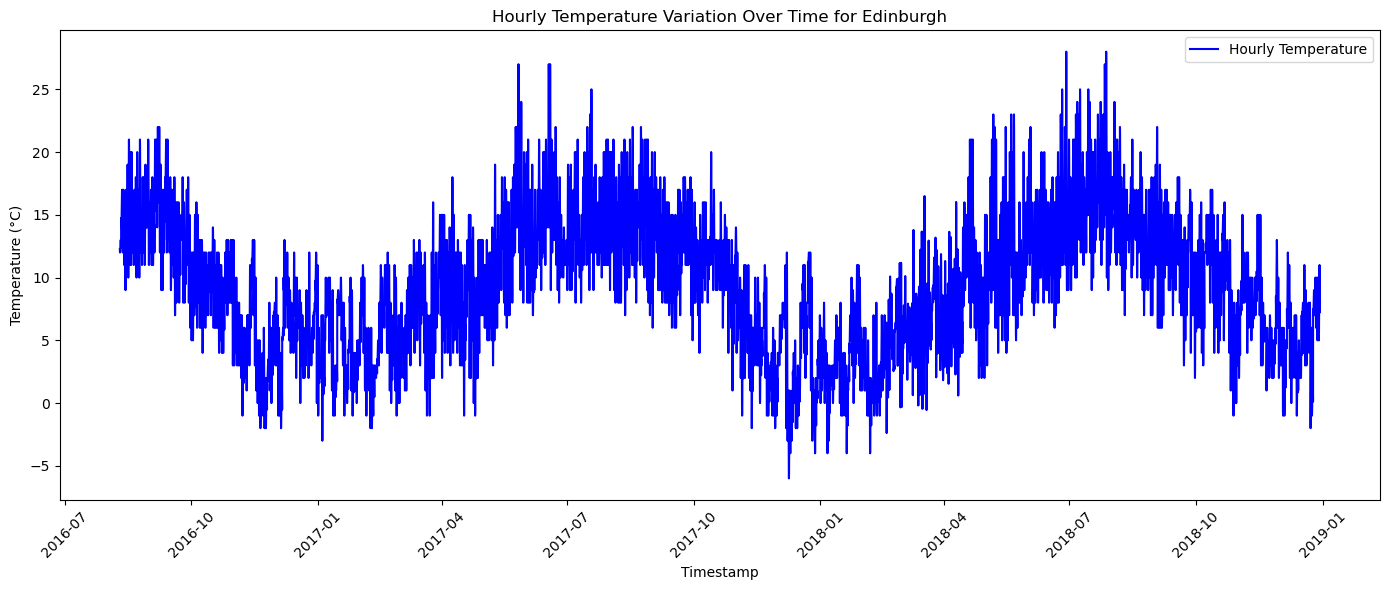

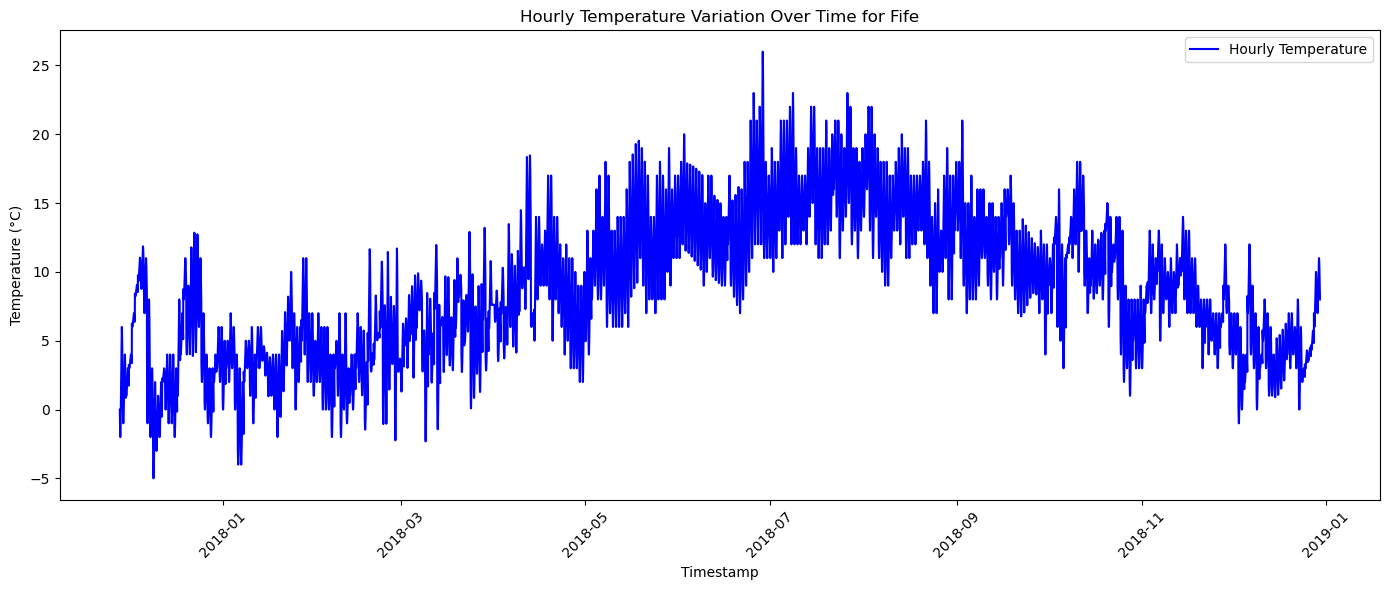

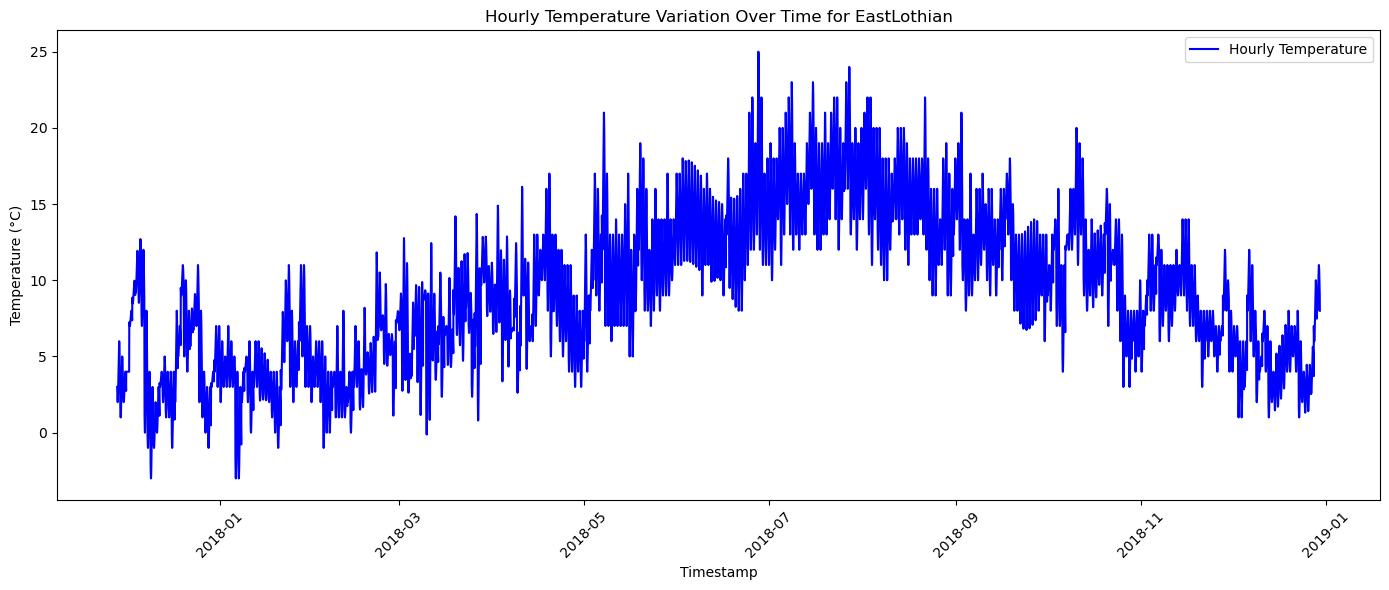

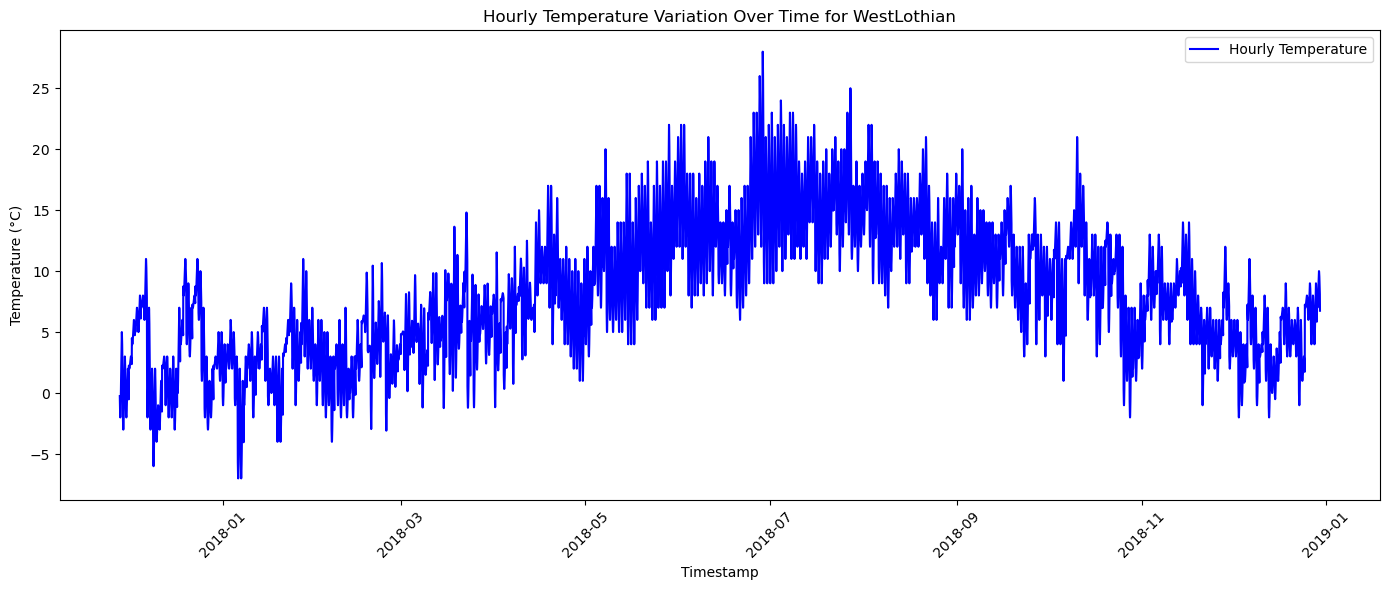

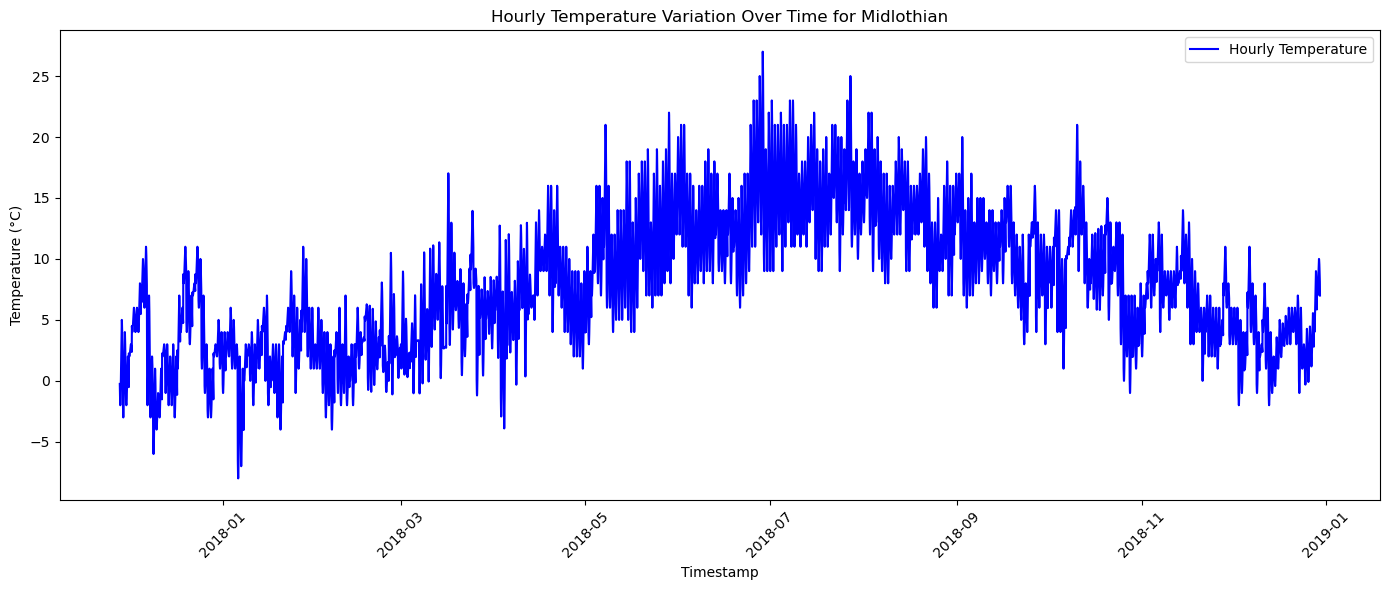

Data for Edinburgh_data saved to cleaned_weather_data_by_location\hourly_temperatures_Edinburgh_data.csv
Data for Fife_data saved to cleaned_weather_data_by_location\hourly_temperatures_Fife_data.csv
Data for EastLothian_data saved to cleaned_weather_data_by_location\hourly_temperatures_EastLothian_data.csv
Data for WestLothian_data saved to cleaned_weather_data_by_location\hourly_temperatures_WestLothian_data.csv
Data for Midlothian_data saved to cleaned_weather_data_by_location\hourly_temperatures_Midlothian_data.csv


In [44]:
output_dir = 'cleaned_weather_data_by_location'
os.makedirs(output_dir, exist_ok=True)

# Define function to retrieve temperature based on timestamp
def get_temperature(ts, hourly_temps_dict, location):
    # converts the timestamps of hourly_timestamp (hours,minutes and seconds) into midnight time to match the key of hourly_temps_dict and stores it to a variable
    date_key = ts.normalize()
    
    # for each normalised date_key, it returns the temperature that corresponds to the 'hour' component of the hourly_timestamps 
    # which means that if the ts.hour is 15 then it will extract the 15th element of the dictionary to match it.
    if location in hourly_temps_dict:
        
        if date_key in hourly_temps_dict[location]:

            # Fetch temperature for the hour
            return hourly_temps_dict[location][date_key][ts.hour]
        else:
            print(f"Date '{date_key}' NOT found for location '{location}'.")
    else:
        print(f"Location '{location}' NOT found in hourly_temps_dict.")

    # Return None if no match is found
    return None

# Iterate through locations and assign temperature
for location_with_suffix in hourly_timestamps_by_location.keys():
    # Extract the base location name
    location = location_with_suffix.replace('_hourly_timestamps', '')

    # Get the DataFrame for the current location
    location_df = hourly_timestamps_by_location[location_with_suffix]

    # Apply the temperature assignment
    location_df['temperature'] = location_df['timestamp'].apply(
        get_temperature, args=(hourly_temps_by_location_dict, location)
    )

    # Update the dictionary with the modified DataFrame
    hourly_timestamps_by_location[location_with_suffix] = location_df
   
   
    
# Plot hourly temperatures for each location
for location, temps in hourly_timestamps_by_location.items():
    hourly_timestamps_by_location[location]['timestamp'] = pd.to_datetime(hourly_timestamps_by_location[location]['timestamp'])
    plt.figure(figsize=(14, 6))
    plt.plot(hourly_timestamps_by_location[location]['timestamp'], hourly_timestamps_by_location[location]['temperature'], color='blue', label='Hourly Temperature')
    plt.xlabel('Timestamp')
    plt.ylabel('Temperature (°C)')
    plt.title(f'Hourly Temperature Variation Over Time for {location.split("_")[0]}')
    plt.legend()
    plt.xticks(rotation=45) 
    plt.tight_layout()  
    plt.show()
    
# Store the files in the specified directory
for location_with_suffix, df in hourly_timestamps_by_location.items():
    base_location = location_with_suffix.replace('_hourly_timestamps', '')
    # Construct the full file path to save in the output directory
    file_path = os.path.join(output_dir, f"hourly_temperatures_{base_location}.csv")
    df.to_csv(file_path, index=False)
    print(f"Data for {base_location} saved to {file_path}")

#### 3.4 Merging Metadata to Gas and Electricity Data for each House

In [45]:
# Paths
METADATA_FILE = r'./raw_data/home_metadata.csv'
DATA_DIR = 'ind-homes-clean'
OUTPUT_DIR = 'ind-homes-clean-modified'

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load the home metadata into a DataFrame
metadata_df = pd.read_csv(METADATA_FILE)

# Iterate over each CSV file in the data directory
for filename in os.listdir(DATA_DIR):
    if filename.endswith('.csv'):
        file_path = os.path.join(DATA_DIR, filename)
        
        # Extract the home ID from the filename
        # e.g., 'home_home306.csv' -> '306'
        parts = filename.replace('.csv', '').split('_')
        if len(parts) >= 2:
            home_id_str = parts[1].replace('home', '')
        else:
            continue  # Skip files that don't match the expected pattern

        # Convert home ID to integer
        try:
            home_id = int(home_id_str)
        except ValueError:
            print(f"Invalid home ID in filename: {filename}")
            continue

        # Find the metadata for this home ID
        home_metadata = metadata_df[metadata_df['homeid'] == home_id]
        if home_metadata.empty:
            print(f"No metadata found for home ID {home_id}")
            continue
        
        # Get the location and other metadata
        location = home_metadata['location'].values[0]
        metadata_dict = home_metadata.to_dict(orient='records')[0]
        metadata_dict.pop('homeid', None)  # Remove 'homeid' from metadata

        # Load the home's data file
        df = pd.read_csv(file_path)

        # Rename the second column to 'elec' and third column to 'gas'
        if df.shape[1] >= 3:
            df.columns.values[1] = 'elec'
            df.columns.values[2] = 'gas'

        # Add metadata columns to the DataFrame
        for key, value in metadata_dict.items():
            df[key] = value  # Fill the entire column with the metadata value

        # Construct the new filename
        new_filename = f"{home_id}_{location}.csv"
        new_file_path = os.path.join(OUTPUT_DIR, new_filename)

        # Save the modified DataFrame
        df.to_csv(new_file_path, index=False)

        print(f"Processed {filename} -> {new_filename}")


Processed home_home100.csv -> 100_Midlothian.csv
Processed home_home107.csv -> 107_Midlothian.csv
Processed home_home113.csv -> 113_WestLothian.csv
Processed home_home116.csv -> 116_Edinburgh.csv
Processed home_home118.csv -> 118_Edinburgh.csv
Processed home_home119.csv -> 119_Edinburgh.csv
Processed home_home121.csv -> 121_Edinburgh.csv
Processed home_home124.csv -> 124_Edinburgh.csv
Processed home_home138.csv -> 138_EastLothian.csv
Processed home_home139.csv -> 139_Edinburgh.csv
Processed home_home146.csv -> 146_Midlothian.csv
Processed home_home148.csv -> 148_Edinburgh.csv
Processed home_home151.csv -> 151_Midlothian.csv
Processed home_home152.csv -> 152_Edinburgh.csv
Processed home_home160.csv -> 160_Edinburgh.csv
Processed home_home161.csv -> 161_Edinburgh.csv
Processed home_home162.csv -> 162_Edinburgh.csv
Processed home_home164.csv -> 164_Midlothian.csv
Processed home_home165.csv -> 165_Edinburgh.csv
Processed home_home167.csv -> 167_Edinburgh.csv
Processed home_home168.csv -> 1

#### 3.5 Merging Weather Data to Gas and Electricity Data for each House

In [46]:
# Paths
INPUT_DIR = 'ind-homes-clean-modified'
WEATHER_DATA_DIR = 'cleaned_weather_data_by_location'
OUTPUT_DIR = 'ind-homes-with-weather'

# Ensure the output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Iterate over each CSV file in the modified data directory
for filename in os.listdir(INPUT_DIR):
    if filename.endswith('.csv'):
        try:
            file_path = os.path.join(INPUT_DIR, filename)
            
            # Extract the location from the filename
            # e.g., '306_Edinburgh.csv' -> 'Edinburgh'
            parts = filename.replace('.csv', '').split('_')
            if len(parts) >= 2:
                location = parts[1]
            else:
                print(f"Could not extract location from filename: {filename}")
                continue  # Skip files that don't match the expected pattern
            
            # Construct the weather data filename
            weather_filename = f'hourly_temperatures_{location}_data.csv'
            weather_file_path = os.path.join(WEATHER_DATA_DIR, weather_filename)
            
            # Check if the weather data file exists
            if not os.path.exists(weather_file_path):
                print(f"Weather data file not found for location '{location}': {weather_filename}")
                continue
            
            # Load the home's data file
            home_df = pd.read_csv(file_path)
            
            # Load the weather data file
            weather_df = pd.read_csv(weather_file_path)
            
            # Ensure 'timestamp' columns are in datetime format
            home_df['timestamp'] = pd.to_datetime(home_df['timestamp'], errors='coerce')
            weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], errors='coerce')
            
            # Merge the weather data into the home data on 'timestamp'
            merged_df = pd.merge(home_df, weather_df[['timestamp', 'temperature']], on='timestamp', how='left')
            
            # Insert the temperature column after 'gas'
            cols = list(merged_df.columns)
            gas_index = cols.index('gas')
            # Remove 'temperature' column and re-insert it after 'gas'
            cols.remove('temperature')
            cols.insert(gas_index + 1, 'temperature')
            merged_df = merged_df[cols]
            
            # Construct the output file path
            output_file_path = os.path.join(OUTPUT_DIR, filename)
            
            # Save the updated DataFrame to the output directory
            merged_df.to_csv(output_file_path, index=False)
            
            print(f"Processed and saved {filename} to {output_file_path}.")
        
        except Exception as e:
            print(f"Skipping {filename} due to an error: {e}")


Processed and saved 100_Midlothian.csv to ind-homes-with-weather\100_Midlothian.csv.
Processed and saved 107_Midlothian.csv to ind-homes-with-weather\107_Midlothian.csv.
Processed and saved 113_WestLothian.csv to ind-homes-with-weather\113_WestLothian.csv.
Processed and saved 116_Edinburgh.csv to ind-homes-with-weather\116_Edinburgh.csv.
Processed and saved 118_Edinburgh.csv to ind-homes-with-weather\118_Edinburgh.csv.
Processed and saved 119_Edinburgh.csv to ind-homes-with-weather\119_Edinburgh.csv.
Processed and saved 121_Edinburgh.csv to ind-homes-with-weather\121_Edinburgh.csv.
Processed and saved 124_Edinburgh.csv to ind-homes-with-weather\124_Edinburgh.csv.
Processed and saved 138_EastLothian.csv to ind-homes-with-weather\138_EastLothian.csv.
Processed and saved 139_Edinburgh.csv to ind-homes-with-weather\139_Edinburgh.csv.
Processed and saved 146_Midlothian.csv to ind-homes-with-weather\146_Midlothian.csv.
Processed and saved 148_Edinburgh.csv to ind-homes-with-weather\148_Edinb

In [39]:
source_dir = 'ind-homes-with-weather'
dest_dir = "ind-homes-final"

# Ensure the destination directory exists
os.makedirs(dest_dir, exist_ok=True)

# Columns to drop
columns_to_remove = [
    "starttime", 
    "starttime_enhanced", 
    "endtime", 
    "cohortid", 
    "urban_rural_class", 
    "new_build_year"
]

# Iterate through each CSV file in the source directory
for filename in os.listdir(source_dir):
    if filename.endswith(".csv"):  # Process only CSV files
        # Define full paths for source and destination files
        source_file = os.path.join(source_dir, filename)
        dest_file = os.path.join(dest_dir, filename)

        # Read the CSV file
        df = pd.read_csv(source_file)

        # Drop the specified columns
        df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')

        # Save the cleaned data to the destination directory
        df_cleaned.to_csv(dest_file, index=False)

        print(f"Processed: {filename}")

print(f"Cleaned CSV files have been saved to: {dest_dir}")

Processed: 100_Midlothian.csv
Processed: 107_Midlothian.csv
Processed: 113_WestLothian.csv
Processed: 116_Edinburgh.csv
Processed: 118_Edinburgh.csv
Processed: 119_Edinburgh.csv
Processed: 121_Edinburgh.csv
Processed: 124_Edinburgh.csv
Processed: 138_EastLothian.csv
Processed: 139_Edinburgh.csv
Processed: 146_Midlothian.csv
Processed: 148_Edinburgh.csv
Processed: 151_Midlothian.csv
Processed: 152_Edinburgh.csv
Processed: 160_Edinburgh.csv
Processed: 161_Edinburgh.csv
Processed: 162_Edinburgh.csv
Processed: 164_Midlothian.csv
Processed: 165_Edinburgh.csv
Processed: 167_Edinburgh.csv
Processed: 168_WestLothian.csv
Processed: 174_Edinburgh.csv
Processed: 175_Midlothian.csv
Processed: 177_Edinburgh.csv
Processed: 182_Edinburgh.csv
Processed: 184_EastLothian.csv
Processed: 186_Edinburgh.csv
Processed: 190_Edinburgh.csv
Processed: 192_Edinburgh.csv
Processed: 199_Edinburgh.csv
Processed: 200_WestLothian.csv
Processed: 202_EastLothian.csv
Processed: 206_EastLothian.csv
Processed: 207_WestLoth

## Chapter 4 - Model Preprocessing and Setup

### 4.1 Data Preprocessing Functions

In [52]:
INPUT_DIR = "ind-homes-final"

def preprocess_data(df):
    """
    Preprocesses input files: handle missing data, ensure timestamps,
    encode categorical variables, and select key fields.
    
    Returns the DataFrame with dummy-encoded columns (if any object dtype).
    """
    # Ensure 'timestamp' is in datetime format and set as index
    if "timestamp" in df.columns:
        df["timestamp"] = pd.to_datetime(df["timestamp"])
        df.set_index("timestamp", inplace=True)
    
    # Reindex to ensure consistent hourly frequency
    if len(df.index) > 0:
        df = df.reindex(pd.date_range(df.index.min(), df.index.max(), freq="h"))
    
    # Fill missing values for 'elec' and 'gas'
    if "elec" in df.columns:
        df["elec"] = df["elec"].interpolate(method="linear").bfill().ffill()
    if "gas" in df.columns:
        df["gas"] = df["gas"].fillna(0)

    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Encode categorical variables using one-hot encoding
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Fill any remaining missing values with zeros
    df.fillna(0, inplace=True)

    return df

def evaluate_model(y_true, y_pred):
    """Compute RMSE for predictions."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse if np.isfinite(rmse) else None

def random_household_selection(num_files=1, exclude=[]):
    """Randomly selects `num_files` household files, excluding the specified ones."""
    all_files = [f for f in os.listdir(INPUT_DIR) if f.endswith(".csv")]
    available_files = [f for f in all_files if f not in exclude]
    return random.sample(available_files, num_files)



## Chapter 5 - Model Training and Comparison
1. Arima (gas/electricity)
2. Sarimax (gas/electricity + weather + metadata)
3. LSTM (gas/electricity + weather + metadata for one home)
4. LSTM (gas/electricity + weather + metadata for all homes)
5. Prophet (gas/electricity for one home)

### 5.1 Functions for Time Series Analysis and Modeling

#### 5.1.1 Arima Functions

In [53]:
# FUNCTIONS FOR ARIMA
def check_stationarity(series, series_name):
    """Perform the Augmented Dickey-Fuller test for stationarity."""
    result = adfuller(series)
    print(f"ADF Statistic for {series_name}: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    if result[1] <= 0.05:
        print(f"The {series_name} series is stationary.")
    else:
        print(f"The {series_name} series is not stationary.")

def fit_arima_and_plot(df, col, home_name):
    """
    Fit ARIMA model and plot fitted vs actual and residual plots for the specified column.
    """
    """Train ARIMA model using fixed order (1, 0, 1) for the target variable."""
    # Stationarity check on electricity consumption
    print("Performing stationarity check on electricity...")
    check_stationarity(df["elec"], "Electricity Consumption")
    
    order = (1, 0, 1)
    model = ARIMA(df[col], order=order)
    fitted_model = model.fit()
    df["fitted"] = fitted_model.fittedvalues
   
    
    # Fitted vs Actual chart
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[col], label="Actual", color="blue")
    plt.plot(df.index, df["fitted"], label="Fitted", color="orange")
    plt.title(f"{home_name} - {col.capitalize()} - Fitted vs Actual", fontsize=16)
    plt.legend()
    plt.show()

    # Residuals chart
    residuals = df[col] - df["fitted"]
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label="Residuals", color="purple")
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"{home_name} - {col.capitalize()} - Residuals", fontsize=16)
    plt.show()

    return fitted_model


def evaluate_arima():
    """Train and evaluate ARIMA on a single random household, test on 5 random households."""
    train_file = random_household_selection(1)[0]
    df_train = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, train_file)))
    train_cols = df_train.columns

    test_files = random_household_selection(5, exclude=[train_file])
    
    home_name = train_file.split("_")[0]
    rmse_dict = {"elec": [], "gas": []}

    for target in ["elec", "gas"]:
        if target not in df_train.columns:
            continue

        arima_model = fit_arima_and_plot(df_train, target, home_name)
        for test_file in test_files:
            df_test = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, test_file)))
            df_test = df_test.reindex(columns=train_cols, fill_value=0)

            if target not in df_test.columns:
                continue

            try:
                forecast = arima_model.forecast(steps=len(df_test))
                rmse = evaluate_model(df_test[target], forecast)
                if rmse is not None:
                    rmse_dict[target].append(rmse)
            except:
                pass

    for t in rmse_dict:
        rmse_dict[t] = np.mean(rmse_dict[t]) if rmse_dict[t] else None
    return rmse_dict

#### 5.1.2 Sarimax Functions

In [54]:
# FUNCTIONS FOR SARIMAX
def fit_sarimax(df, target_col):
    """Train SARIMAX model using extra covariates (all other columns)."""
    exogenous_columns = df.columns.difference([target_col])
    exog = df[exogenous_columns]

    # Ensure exogenous variables are numeric and no missing
    exog = exog.select_dtypes(include=[np.number])
    exog.fillna(0, inplace=True)

    model = SARIMAX(df[target_col], exog=exog, order=(1, 0, 1))
    fitted_model = model.fit(disp=False)
    return fitted_model

def evaluate_sarimax():
    """Train and evaluate SARIMAX on a single random household, test on 5 random households."""
    train_file = random_household_selection(1)[0]
    df_train = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, train_file)))
    train_cols = df_train.columns

    test_files = random_household_selection(5, exclude=[train_file])
    rmse_dict = {"elec": [], "gas": []}

    for target in ["elec", "gas"]:
        if target not in df_train.columns:
            continue

        sarimax_model = fit_sarimax(df_train, target_col=target)
        for test_file in test_files:
            df_test = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, test_file)))
            df_test = df_test.reindex(columns=train_cols, fill_value=0)

            if target not in df_test.columns:
                continue

            exog_test = df_test[df_test.columns.difference([target])]
            exog_test = exog_test.select_dtypes(include=[np.number]).fillna(0)

            try:
                forecast = sarimax_model.forecast(steps=len(df_test), exog=exog_test)
                forecast = forecast[:len(df_test[target])]
                rmse = evaluate_model(df_test[target], forecast)
                if rmse is not None:
                    rmse_dict[target].append(rmse)
            except Exception as e:
                print(f"Error during SARIMAX evaluation for {test_file}: {e}")

    for t in rmse_dict:
        rmse_dict[t] = np.mean(rmse_dict[t]) if rmse_dict[t] else None
    return rmse_dict


#### 5.1.3 LSTM On Single Household Functions

In [55]:
# FUNCTIONS FOR LSTM ON A SINGLE HOUSEHOLD
def fit_lstm_single(df, target_col):
    """Train LSTM model on one household for a single target variable."""
    # Drop rows where target is missing
    df = df.dropna(subset=[target_col])
    
    # Separate features/target
    data = df.drop(columns=[target_col]).values
    target = df[target_col].values

    # Scale features and target
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    data_scaled = scaler_X.fit_transform(data)
    target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

    # Create sequences
    sequence_len = 24  # Use previous 24 hours as input
    X, y = [], []
    for i in range(sequence_len, len(data_scaled)):
        X.append(data_scaled[i - sequence_len:i])
        y.append(target_scaled[i])
    X, y = np.array(X), np.array(y)

    # Build LSTM model
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2])),
        LSTM(50, return_sequences=True),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    model.fit(X, y, epochs=10, batch_size=32, verbose=0)

    return model, scaler_X, scaler_y

def evaluate_lstm_single():
    """Train and evaluate LSTM on a single random household, test on 5 random households."""
    train_file = random_household_selection(1)[0]
    df_train = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, train_file)))
    train_cols = df_train.columns

    test_files = random_household_selection(5, exclude=[train_file])
    rmse_dict = {"elec": [], "gas": []}

    for target in ["elec", "gas"]:
        if target not in df_train.columns:
            continue

        lstm_model, scaler_X, scaler_y = fit_lstm_single(df_train, target)

        for test_file in test_files:
            df_test = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, test_file)))
            df_test = df_test.reindex(columns=train_cols, fill_value=0)

            if target not in df_test.columns:
                continue
            df_test = df_test.dropna(subset=[target])

            data_test = df_test.drop(columns=[target]).values
            target_test = df_test[target].values

            data_test_scaled = scaler_X.transform(data_test)

            sequence_len = 24
            X_test = []
            for i in range(sequence_len, len(data_test_scaled)):
                X_test.append(data_test_scaled[i - sequence_len:i])
            X_test = np.array(X_test)
            y_test = target_test[sequence_len:]

            y_pred_scaled = lstm_model.predict(X_test)
            y_pred = scaler_y.inverse_transform(y_pred_scaled)

            rmse = evaluate_model(y_test, y_pred.flatten())
            if rmse is not None:
                rmse_dict[target].append(rmse)

    for t in rmse_dict:
        rmse_dict[t] = np.mean(rmse_dict[t]) if rmse_dict[t] else None
    return rmse_dict

#### 5.1.4 LSTM On Multiple Households Functions

In [56]:
# FUNCTIONS FOR LSTM SEQUENTIAL TRAINING ON MULTIPLE HOUSEHOLDS
def fit_lstm_sequential(train_dfs, target_col):
    """
    Train LSTM model sequentially on multiple DataFrames (already preprocessed & reindexed).
    Returns the final model and the scalers.
    """
    model, scaler_X, scaler_y = None, None, None
    sequence_len = 24

    for idx, df in enumerate(train_dfs):
        df = df.dropna(subset=[target_col])
        data = df.drop(columns=[target_col]).values
        target = df[target_col].values

        # Initialize scalers if first iteration
        if model is None:
            # First file dictates the shape and initializes everything
            scaler_X = MinMaxScaler()
            scaler_y = MinMaxScaler()

            data_scaled = scaler_X.fit_transform(data)
            target_scaled = scaler_y.fit_transform(target.reshape(-1, 1))

            # Build model
            model = Sequential([
                Input(shape=(sequence_len, data_scaled.shape[1])),
                LSTM(50, return_sequences=True),
                LSTM(50),
                Dense(1)
            ])
            model.compile(optimizer="adam", loss="mse")
        else:
            # For subsequent files, transform with existing scalers
            data_scaled = scaler_X.transform(data)
            target_scaled = scaler_y.transform(target.reshape(-1, 1))

        # Create sequences
        X, y = [], []
        for i in range(sequence_len, len(data_scaled)):
            X.append(data_scaled[i - sequence_len:i])
            y.append(target_scaled[i])
        X, y = np.array(X), np.array(y)

        # Train the model incrementally
        model.fit(X, y, epochs=5, batch_size=32, verbose=0)

    return model, scaler_X, scaler_y

def evaluate_lstm_sequential():
    """
    Train LSTM sequentially on 20 random households, then evaluate on 5 random households,
    returning separate RMSE for elec and gas.
    """
    train_files = random_household_selection(20)
    test_files = random_household_selection(5, exclude=train_files)

    train_dfs = []
    union_train_cols = set()

    for f in train_files:
        df_temp = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, f)))
        train_dfs.append(df_temp)
        union_train_cols = union_train_cols.union(df_temp.columns)
    union_train_cols = list(union_train_cols)

    # Reindex each train df to the union of columns
    for idx, df_temp in enumerate(train_dfs):
        train_dfs[idx] = df_temp.reindex(columns=union_train_cols, fill_value=0)

    rmse_dict = {"elec": [], "gas": []}

    for target in ["elec", "gas"]:
        if target not in union_train_cols:
            continue

        lstm_model, scaler_X, scaler_y = fit_lstm_sequential(train_dfs, target)

        # Evaluate on test files
        for test_file in test_files:
            df_test = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, test_file)))
            df_test = df_test.reindex(columns=union_train_cols, fill_value=0)

            if target not in df_test.columns:
                continue
            df_test = df_test.dropna(subset=[target])

            data_test = df_test.drop(columns=[target]).values
            target_test = df_test[target].values
            data_test_scaled = scaler_X.transform(data_test)

            sequence_len = 24
            X_test = []
            for i in range(sequence_len, len(data_test_scaled)):
                X_test.append(data_test_scaled[i - sequence_len:i])
            X_test = np.array(X_test)
            y_true = target_test[sequence_len:]

            y_pred_scaled = lstm_model.predict(X_test)
            y_pred = scaler_y.inverse_transform(y_pred_scaled)

            rmse = evaluate_model(y_true, y_pred.flatten())
            if rmse is not None:
                rmse_dict[target].append(rmse)

    for t in rmse_dict:
        rmse_dict[t] = np.mean(rmse_dict[t]) if rmse_dict[t] else None
    return rmse_dict


#### 5.1.5 Phophet on Single Household Functions

In [66]:
# Functions for Prophet training on a single household and evaluation of the model using other households' data
def fit_prophet(df, target_col):
    """
    Train a Prophet model using the given DataFrame (with 'timestamp' as index) for target_col.
    We temporarily reset the index, rename columns to Prophet's required format (ds, y),
    fit, and return the model.
    """
    # Prophet requires a column named 'ds' for time and 'y' for the target
    # Temporarily reset index to a column
    df_prophet = df.reset_index().rename(columns={'index': 'ds', target_col: 'y'})
    
    # Only keep ds and y
    df_prophet = df_prophet[['ds', 'y']]
    
    # Prophet requires no missing values
    df_prophet.dropna(inplace=True)
    
    # Instantiate and fit Prophet
    model = Prophet()
    model.fit(df_prophet)
    return model

def evaluate_prophet():
    """
    Train and evaluate a Prophet model on a single random household (train),
    then test on 5 random households. Return average RMSE for 'elec' and 'gas'.
    """
    if Prophet is None:
        print("Prophet not installed. Skipping Prophet evaluation.")
        return {"elec": None, "gas": None}

    train_file = random_household_selection(1)[0]
    df_train = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, train_file)))
    train_cols = df_train.columns

    test_files = random_household_selection(5, exclude=[train_file])
    rmse_dict = {"elec": [], "gas": []}

    for target in ["elec", "gas"]:
        if target not in df_train.columns:
            continue

        prophet_model = fit_prophet(df_train, target)
        for test_file in test_files:
            df_test = preprocess_data(pd.read_csv(os.path.join(INPUT_DIR, test_file)))
            df_test = df_test.reindex(columns=train_cols, fill_value=0)

            if target not in df_test.columns:
                continue
            
            # Length of test set
            test_len = len(df_test)
            if test_len == 0:
                continue
            
            # Prophet forecasting approach:
            #   We create a future dataframe for the test horizon
            #   For hourly data, we do freq='h' 
            df_train_index = df_train.index
            last_train_timestamp = df_train_index.max()

            # Make a future DataFrame of length test_len hours beyond last train timestamp
            future_dates = pd.date_range(start=last_train_timestamp, periods=test_len+1, freq='h')[1:]
            
            # Prophet needs a DataFrame with 'ds' column
            future_df = pd.DataFrame({'ds': future_dates})
            
            forecast = prophet_model.predict(future_df)
            y_pred = forecast['yhat'].values  # predicted values
            # True test values
            y_true = df_test[target].values
            
            rmse = evaluate_model(y_true, y_pred)
            if rmse is not None:
                rmse_dict[target].append(rmse)

    for t in rmse_dict:
        rmse_dict[t] = np.mean(rmse_dict[t]) if rmse_dict[t] else None
    return rmse_dict

### 5.3 Models' Execution

In [58]:
results = {} # store models' performance

#### 5.3.1 Arima

Evaluating ARIMA Model...
Performing stationarity check on electricity...
ADF Statistic for Electricity Consumption: -5.3281
p-value: 0.0000
The Electricity Consumption series is stationary.


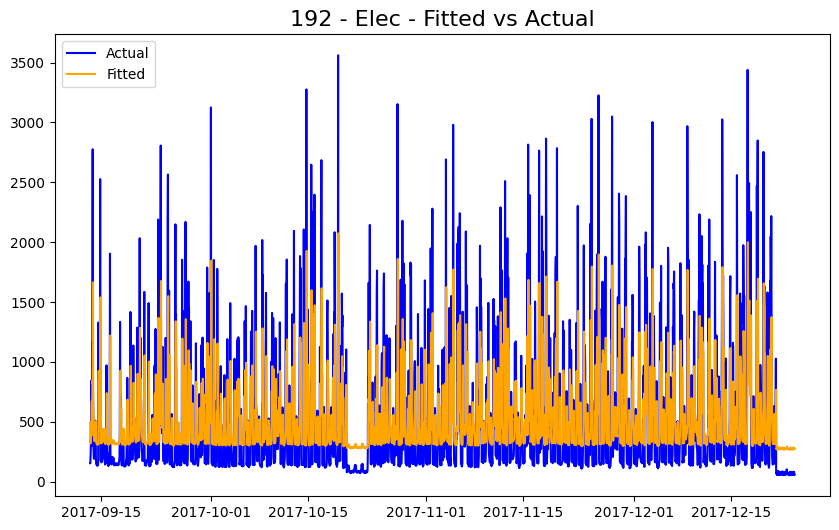

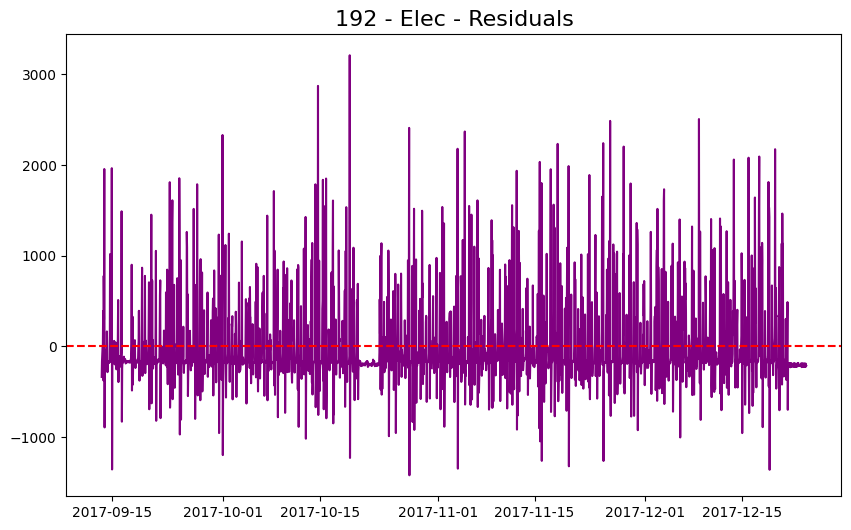

Performing stationarity check on electricity...
ADF Statistic for Electricity Consumption: -5.3281
p-value: 0.0000
The Electricity Consumption series is stationary.


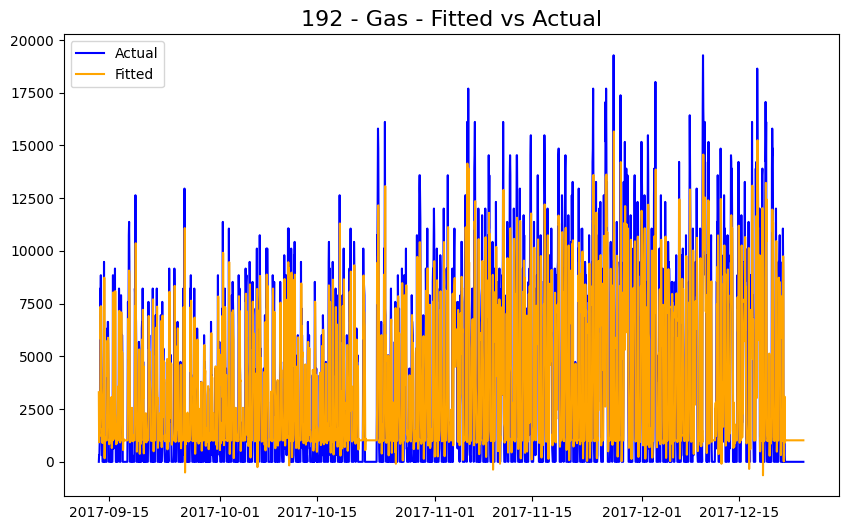

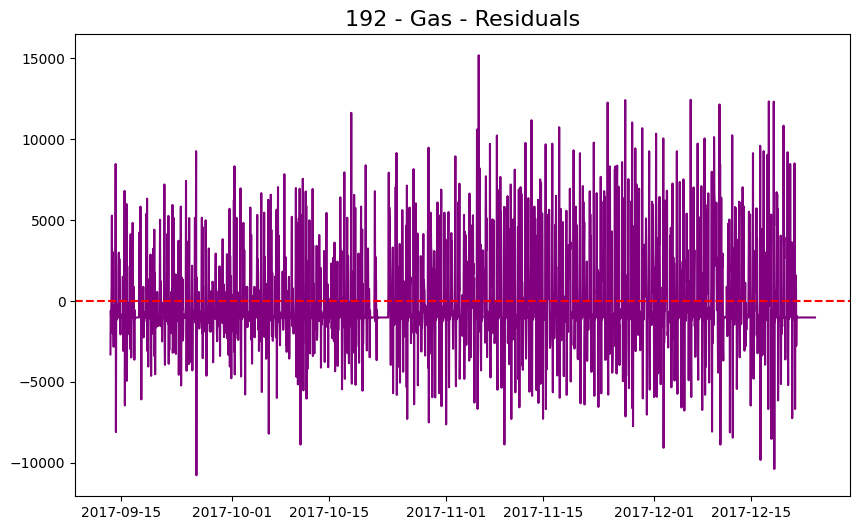

In [59]:
print("Evaluating ARIMA Model...")
try:
    arima_results = evaluate_arima()
    results["ARIMA"] = arima_results
except Exception as e:
    print(f"ARIMA evaluation failed: {e}")
    results["ARIMA"] = {"elec": None, "gas": None}

#### 5.3.2 Sarimax

In [60]:
print("Evaluating SARIMAX Model...")
try:
    sarimax_results = evaluate_sarimax()
    results["SARIMAX"] = sarimax_results
except Exception as e:
    print(f"SARIMAX evaluation failed: {e}")
    results["SARIMAX"] = {"elec": None, "gas": None}

Evaluating SARIMAX Model...


#### 5.3.3 LSTM (ONE HOME)

In [61]:
print("Evaluating Single-Household LSTM...")
try:
    lstm_single_results = evaluate_lstm_single()
    results["LSTM Single"] = lstm_single_results
except Exception as e:
    print(f"LSTM Single evaluation failed: {e}")
    results["LSTM Single"] = {"elec": None, "gas": None}

Evaluating Single-Household LSTM...
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
154/154 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step


#### 5.3.4 Sequential LSTM (ALL HOMES)

In [62]:
print("Evaluating LSTM Sequential Training...")
try:
    lstm_seq_results = evaluate_lstm_sequential()
    results["LSTM Sequential"] = lstm_seq_results
except Exception as e:
    print(f"LSTM Sequential evaluation failed: {e}")
    results["LSTM Sequential"] = {"elec": None, "gas": None}

Evaluating LSTM Sequential Training...
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
275/275 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


#### 5.3.5 Prophet

In [67]:
print("Evaluating Prophet Model...")
try:
    prophet_results = evaluate_prophet()
    results["PROPHET"] = prophet_results
except Exception as e:
    print(f"Prophet evaluation failed: {e}")
    results["PROPHET"] = {"elec": None, "gas": None}

16:22:51 - cmdstanpy - INFO - Chain [1] start processing


Evaluating Prophet Model...


16:22:51 - cmdstanpy - INFO - Chain [1] done processing
16:22:56 - cmdstanpy - INFO - Chain [1] start processing
16:22:56 - cmdstanpy - INFO - Chain [1] done processing


### 5.4 Comparison of Models' Performance

In [68]:
# Display results
print("\nEvaluation Results (RMSE for Elec and Gas):")
for model_name, rmse_dict in results.items():
    elec_rmse = rmse_dict.get("elec", "N/A")
    gas_rmse = rmse_dict.get("gas", "N/A")
    elec_rmse_str = f"{elec_rmse:.3f}" if elec_rmse not in [None, "N/A"] else "N/A"
    gas_rmse_str = f"{gas_rmse:.3f}" if gas_rmse not in [None, "N/A"] else "N/A"
    print(f"{model_name} -> Elec RMSE: {elec_rmse_str} | Gas RMSE: {gas_rmse_str}")


Evaluation Results (RMSE for Elec and Gas):
ARIMA -> Elec RMSE: 4579.267 | Gas RMSE: 2936.300
SARIMAX -> Elec RMSE: 1231.687 | Gas RMSE: 2937.412
LSTM Single -> Elec RMSE: 990.731 | Gas RMSE: 5266.041
LSTM Sequential -> Elec RMSE: 1178.299 | Gas RMSE: 2984.296
PROPHET -> Elec RMSE: 2482.880 | Gas RMSE: 12197.262
